# 統合予測結果分析・図生成ノートブック

このノートブックは `generate_final_figures.py` の機能を Jupyter Notebook で実行できるようにしたものです。

Author: Generated from notebooks integration  
Date: 2025-10-26

## 1. ライブラリのインポート

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from pathlib import Path

# 日本語フォントの設定（文字化け対策）
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("ライブラリのインポート完了")

ライブラリのインポート完了


## 2. BioisosterePredictionAnalyzer クラスの定義

元のスクリプトから分析クラスをインポートします。

In [2]:
# 現在のディレクトリを確認
current_dir = Path.cwd()
print(f"現在のディレクトリ: {current_dir}")

# スクリプトがあるディレクトリをパスに追加（必要に応じて）
test_dir = current_dir if current_dir.name == 'test' else current_dir / 'test'
if str(test_dir) not in sys.path:
    sys.path.insert(0, str(test_dir))

# クラスをインポート
from generate_final_figures import BioisosterePredictionAnalyzer

print("BioisosterePredictionAnalyzer クラスのインポート完了")

現在のディレクトリ: /gs/bs/tga-ohuelab/masunaga/bioiso/test
BioisosterePredictionAnalyzer クラスのインポート完了


In [3]:
# モジュールを再読み込み（修正後に必要）
import importlib
if 'generate_final_figures' in sys.modules:
    importlib.reload(sys.modules['generate_final_figures'])
    print("generate_final_figures モジュールを再読み込みしました")
else:
    print("初回読み込みです")

generate_final_figures モジュールを再読み込みしました


## 3. パラメータ設定

分析に必要なパラメータを設定します。必要に応じて編集してください。

In [ ]:
# === パラメータ設定 ===

# ベースディレクトリ（Noneの場合は自動検出）
base_dir = None

# 結果CSVファイルの出力ディレクトリ（Noneの場合は自動生成）
results_dir = None

# 図の出力ディレクトリ（Noneの場合は自動生成）
figures_dir = None

# Cross-validationデータのpklファイル（Noneの場合は自動検出）
# 例: '../splitting/tid_5cv_consistentsmiles.pkl'
cv_pkl_file = None
cv_pkl_file = 'bioiso/splitting/tid_5cv_consistentsmiles_molecule.pkl'  # 直接指定する場合

# LGBM予測結果のディレクトリ（Noneの場合はデフォルト: gbdt）
lgbm_predictions_dir = None
lgbm_predictions_dir = "../gbdt/results_consistentsmiles-2048"

# GNN予測結果のディレクトリ（リスト形式、Noneの場合はデフォルト: ["pro_GNN/results"]）
gnn_predictions_dirs = None
gnn_predictions_dirs = ['../pro_GNN/results/results_consistentsmiles_molecule']
# gnn_predictions_dirs = ['../pro_GNN/results/baseline_gcn_consistentsmiles_tid3_molecule']
# # 例: 複数ディレクトリを指定する場合
# gnn_predictions_dirs = [
#     '../pro_GNN/results/baseline_gcn_consistentsmiles',
#     '../pro_GNN/results/baseline_gin_consistentsmiles',
#     '../pro_GNN/results/baseline_gin_edge_consistentsmiles',

# ]

# GNN結果CSVファイルを直接指定（複数GNN統合用、Noneの場合は上記のディレクトリから自動検出）
gnn_csv_files = None
# gnn_csv_files = [
#     'results_consistentsmiles/gnn_results_df_single.csv',
#     'results_gcn_consistentsmiles/gnn_results_df_single.csv',
#     'results_gin_consistentsmiles/gnn_results_df_single.csv',
#     'results_gin_edge_consistentsmiles/gnn_results_df_single.csv',

# ]

# 図の出力形式
figure_format = 'png'  # 'png', 'pdf', 'svg', 'eps' から選択

# LGBMモデルの結果を含めるかどうか
include_lgbm = True  # True にするとLGBMも含めて分析

# 比較モード
# 'merge': 同じモデルの結果を統合（デフォルト、複数フォールドの結果をまとめる）
# 'compare': 異なる条件（frag vs 通常など）を比較
comparison_mode = 'merge'  # または

# 計算をスキップして既存のCSVから図のみ生成するかどうか
skip_calculation = False  # True にすると既存CSVから図のみ生成

print("パラメータ設定完了")
print(f"  CVファイル: {cv_pkl_file if cv_pkl_file else '自動検出'}")
print(f"  GNN予測ディレクトリ: {gnn_predictions_dirs}")
print(f"  LGBMを含める: {include_lgbm}")
print(f"  比較モード: {comparison_mode}")
print(f"  計算スキップ: {skip_calculation}")
print(f"  図の出力形式: {figure_format}")

パラメータ設定完了
  CVファイル: bioiso/splitting/tid_5cv_consistentsmiles_tid3_molecule.pkl
  GNN予測ディレクトリ: ['../pro_GNN/results/results_consistentsmiles_tid3_molecule']
  LGBMを含める: True
  比較モード: merge
  計算スキップ: False
  図の出力形式: png


## 4. アナライザーの初期化

In [15]:
# アナライザーを初期化
analyzer = BioisosterePredictionAnalyzer(
    base_dir=base_dir,
    results_dir=results_dir,
    figures_dir=figures_dir,
    lgbm_predictions_dir=lgbm_predictions_dir,
    gnn_predictions_dirs=gnn_predictions_dirs,
    figure_format=figure_format,
    include_lgbm=include_lgbm,
    comparison_mode=comparison_mode,
    cv_pkl_file=cv_pkl_file  # pklファイルを指定
)

# CSV直接指定の場合
if gnn_csv_files:
    analyzer.gnn_csv_files = [Path(f) for f in gnn_csv_files]
else:
    analyzer.gnn_csv_files = None

# 設定の表示
print("=== アナライザー設定 ===")
print(f"ベースディレクトリ: {analyzer.base_dir}")
print(f"CVファイル: {analyzer.cv_pkl_file if analyzer.cv_pkl_file else '自動検出'}")
print(f"結果出力ディレクトリ: {analyzer.results_dir}")
print(f"図出力ディレクトリ: {analyzer.figures_dir}")
print(f"LGBM予測結果ディレクトリ: {analyzer.lgbm_predictions_dir}")
print(f"GNN予測結果ディレクトリ ({len(analyzer.gnn_predictions_dirs)}個):")
for i, dir_path in enumerate(analyzer.gnn_predictions_dirs, 1):
    print(f"  {i}. {dir_path}")
print(f"LGBMを含める: {include_lgbm}")
print(f"比較モード: {comparison_mode}")

=== アナライザー設定 ===
ベースディレクトリ: /gs/bs/tga-ohuelab/masunaga
CVファイル: bioiso/splitting/tid_5cv_consistentsmiles_tid3_molecule.pkl
結果出力ディレクトリ: /gs/bs/tga-ohuelab/masunaga/bioiso/test/results_consistentsmiles_tid3_molecule
図出力ディレクトリ: /gs/bs/tga-ohuelab/masunaga/bioiso/test/figures_consistentsmiles_tid3_molecule
LGBM予測結果ディレクトリ: ../gbdt/results_consistentsmiles-2048
GNN予測結果ディレクトリ (1個):
  1. ../pro_GNN/results/results_consistentsmiles_tid3_molecule
LGBMを含める: True
比較モード: merge


## 4.5 予測ファイルのテスト読み込み（デバッグ用）

実際に予測ファイルが正しく読み込めるかテストします。

In [16]:
# # テスト: 予測ファイルの読み込みを確認
# test_pred_path = Path('../pro_GNN/results/results_consistentsmiles_triple/cv0/pair-concat/test_predictions.npz')

# if test_pred_path.exists():
#     print(f"予測ファイルを確認: {test_pred_path}")
#     pred_data = np.load(test_pred_path)
#     print(f"利用可能なキー: {list(pred_data.keys())}")
    
#     # 2グラフ版と3グラフ版の自動判別をテスト
#     if "y_prob_ab" in pred_data:
#         print("→ 2グラフ版（通常のペア）を検出")
#         pred = pred_data["y_prob_ab"][:,1]
#     elif "y_prob" in pred_data:
#         print("→ 3グラフ版（triple）を検出")
#         pred = pred_data["y_prob"][:,1]
#     else:
#         print("→ 未知の形式")
    
#     print(f"予測値の形状: {pred.shape}")
#     print(f"予測値の範囲: [{pred.min():.4f}, {pred.max():.4f}]")
# else:
#     print(f"ファイルが見つかりません: {test_pred_path}")

## 5. 分析の実行

### オプション A: 予測結果から完全な分析を実行（推奨）

=== 予測結果から完全な分析を実行 ===
=== バイオアイソスター予測結果分析を開始 ===
データを読み込み中...
指定されたCross-validation データを読み込み: /gs/bs/tga-ohuelab/masunaga/bioiso/splitting/tid_5cv_consistentsmiles_tid3_molecule.pkl


  → 5 フォールドのデータを読み込みました
LGBM評価用データを読み込み: dataset_consistentsmiles-2048.joblib
  レコード数: 643937
データの読み込みが完了しました
GNN予測結果から結果を計算中...
Processing fold 0
  Test set size: 18008
  Filtered test set size: 8143
  Available indices (single label): 8143/18008
  Model pair-cat: prediction size = 18008
  Model pair-diff: prediction size = 18008
  Model pair-product: prediction size = 18008
Processing fold 1
  Test set size: 14098
  Filtered test set size: 7348
  Available indices (single label): 7348/14098
  Model pair-cat: prediction size = 14098
  Model pair-diff: prediction size = 14098
  Model pair-product: prediction size = 14098
Processing fold 2
  Test set size: 11240
  Filtered test set size: 6444
  Available indices (single label): 6444/11240
  Model pair-cat: prediction size = 11240
  Model pair-diff: prediction size = 11240
  Model pair-product: prediction size = 11240
Processing fold 3
  Test set size: 12075
  Filtered test set size: 8090
  Available indices (single label): 8090/12075
  

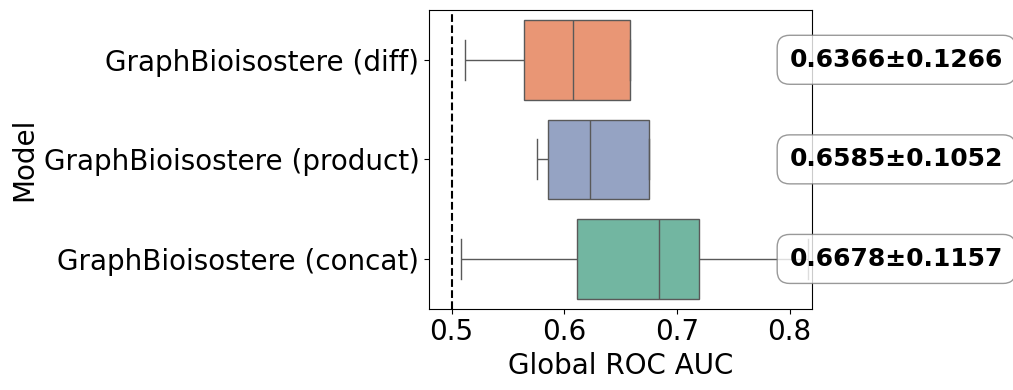

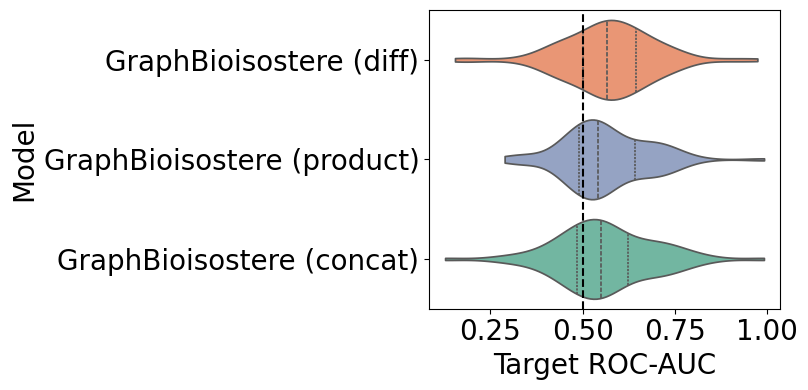


=== モデル性能統計 ===
                              mean     std  count
Model                                            
GraphBioisostere (concat)   0.6678  0.1157      5
GraphBioisostere (diff)     0.6366  0.1266      5
GraphBioisostere (product)  0.6585  0.1052      5

最良モデル: GraphBioisostere (concat) (AUC: 0.6678)

Tanimoto類似度別の分析を実行します...

Tanimoto類似度別の分析を実行中...
  モデル数: 3
  処理中: GraphBioisostere (concat)
    GraphBioisostere (concat): 5 フォールド分のデータを収集
  処理中: GraphBioisostere (diff)
    GraphBioisostere (diff): 5 フォールド分のデータを収集
  処理中: GraphBioisostere (product)
    GraphBioisostere (product): 5 フォールド分のデータを収集

  Tanimotoビン別のROC AUC計算中...
    GraphBioisostere (concat): 37 データポイント（Fold x Tanimotoビン）を収集
    GraphBioisostere (diff): 37 データポイント（Fold x Tanimotoビン）を収集
    GraphBioisostere (product): 37 データポイント（Fold x Tanimotoビン）を収集
Tanimoto分析結果を保存: /gs/bs/tga-ohuelab/masunaga/bioiso/test/results_consistentsmiles_tid3_molecule/tanimoto_analysis.csv

Tanimoto分析対象モデル数: 3
各モデルについて5フォールドの平均と標準偏差を計算

G

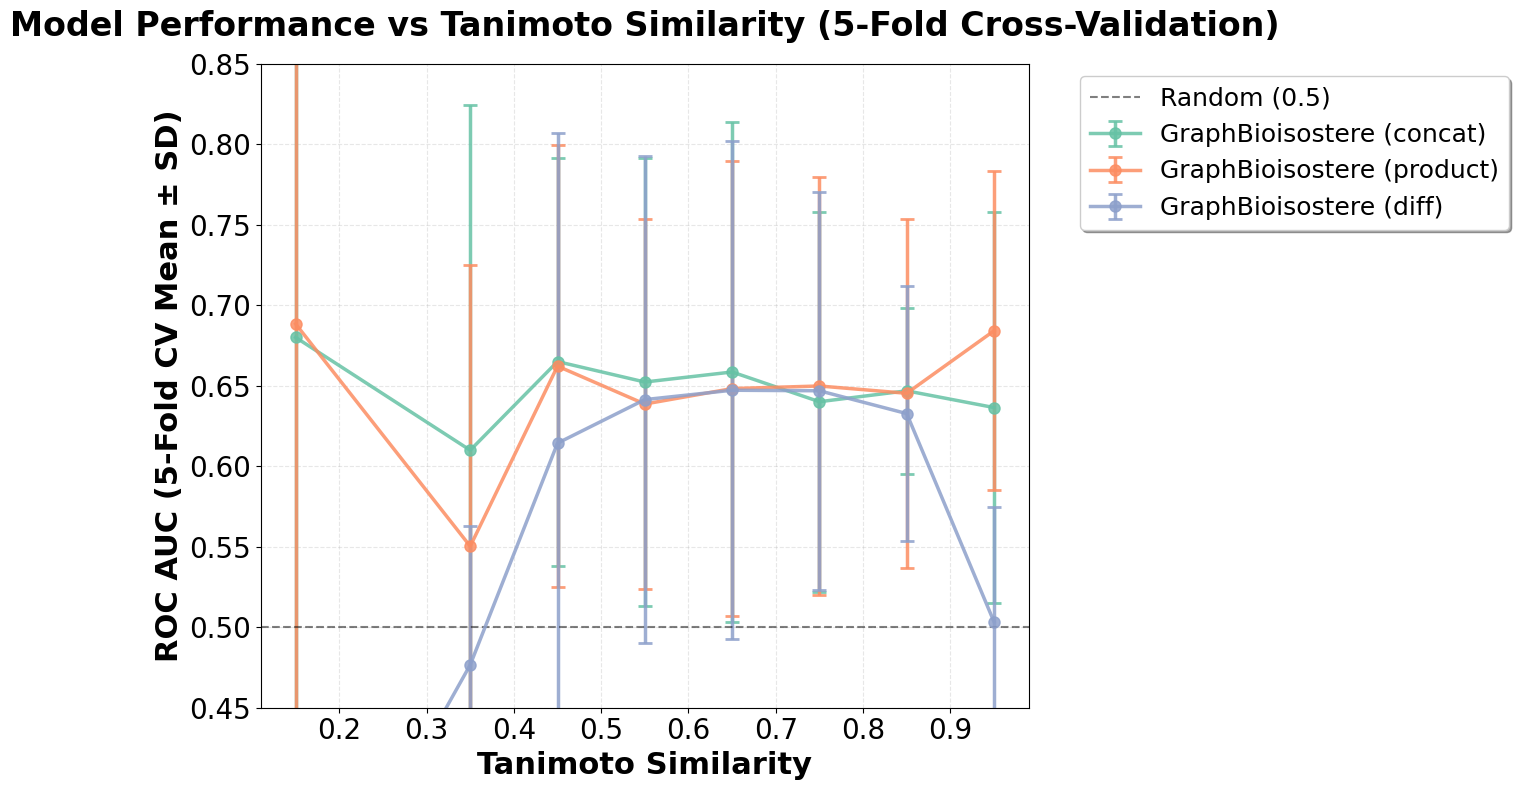

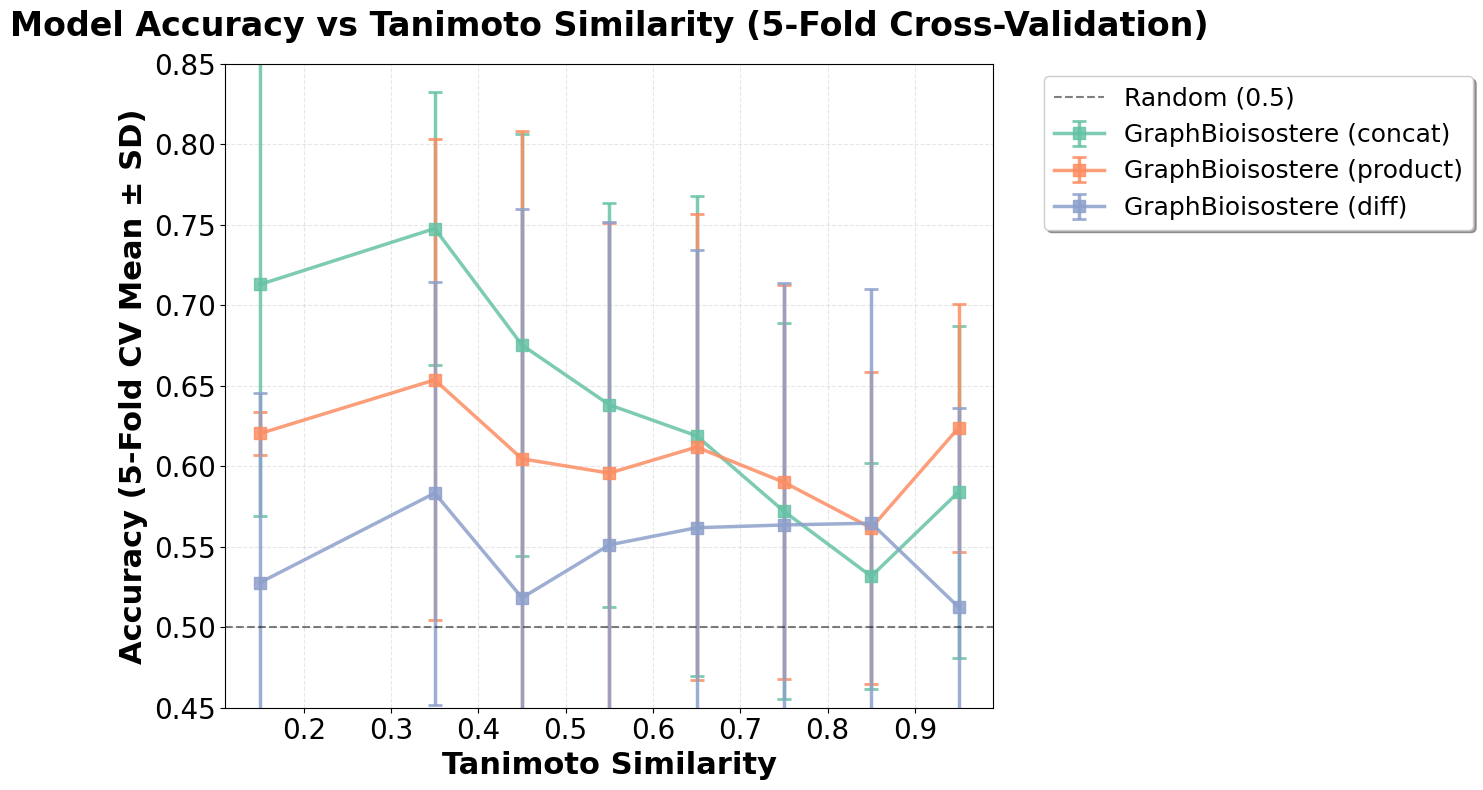

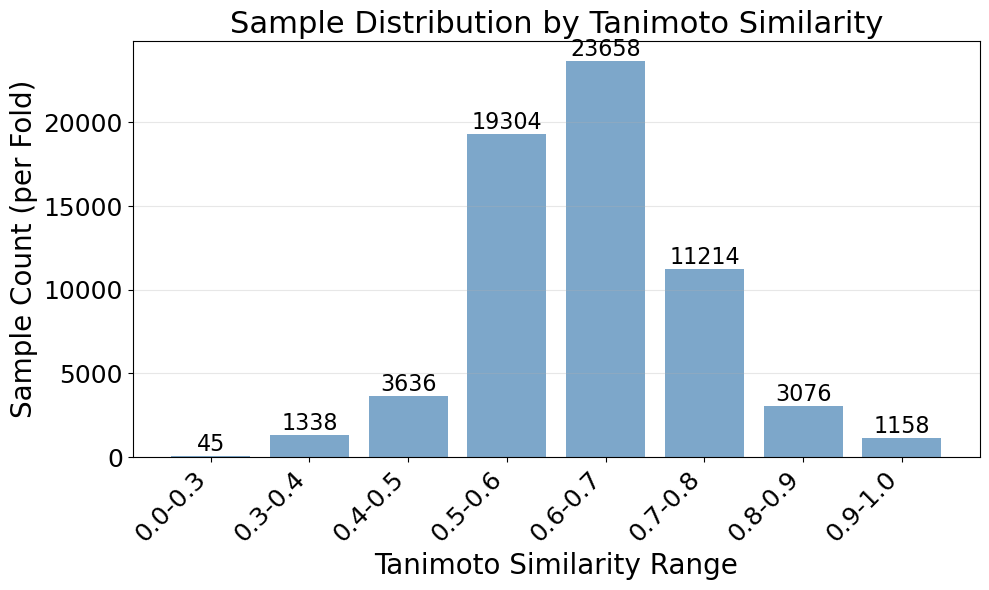


Tanimoto類似度別の図を保存しました:
  - /gs/bs/tga-ohuelab/masunaga/bioiso/test/figures_consistentsmiles_tid3_molecule/tanimoto_vs_rocauc_5fold.png
  - /gs/bs/tga-ohuelab/masunaga/bioiso/test/figures_consistentsmiles_tid3_molecule/tanimoto_vs_accuracy_5fold.png
  - /gs/bs/tga-ohuelab/masunaga/bioiso/test/figures_consistentsmiles_tid3_molecule/tanimoto_sample_distribution.png
図の生成が完了しました
=== 分析が完了しました ===
結果は /gs/bs/tga-ohuelab/masunaga/bioiso/test/results_consistentsmiles_tid3_molecule に保存されました
図は /gs/bs/tga-ohuelab/masunaga/bioiso/test/figures_consistentsmiles_tid3_molecule に保存されました

分析が完了しました！
結果は /gs/bs/tga-ohuelab/masunaga/bioiso/test/results_consistentsmiles_tid3_molecule に保存されました
図は /gs/bs/tga-ohuelab/masunaga/bioiso/test/figures_consistentsmiles_tid3_molecule に保存されました


In [17]:
# skip_calculation = False の場合にこのセルを実行
if not skip_calculation:
    print("=== 予測結果から完全な分析を実行 ===")
    analyzer.run_full_analysis()
    print("\n分析が完了しました！")
    print(f"結果は {analyzer.results_dir} に保存されました")
    print(f"図は {analyzer.figures_dir} に保存されました")
else:
    print("skip_calculation=True のため、このセルはスキップされます")

### オプション B: 既存のCSVから図のみ生成

In [ ]:
# skip_calculation = True の場合にこのセルを実行
if skip_calculation:
    print("=== 既存結果から図を生成 ===")
    try:
        # 既存のCSVファイルから結果を読み込み
        results_data = analyzer.load_existing_results()
        analyzer.generate_figures(results_data)
        print("\n図の生成が完了しました！")
        print(f"図は {analyzer.figures_dir} に保存されました")
    except Exception as e:
        print(f"エラー: 既存結果の読み込みに失敗しました: {e}")
        print("skip_calculation=True を使う場合、結果CSVファイルが存在している必要があります。")
else:
    print("skip_calculation=False のため、このセルはスキップされます")

skip_calculation=False のため、このセルはスキップされます


## 6. 結果の確認

生成された結果ファイルを確認します。

In [ ]:
# 結果ディレクトリの内容を表示
print("=== 生成されたファイル ===")
print(f"\n結果ディレクトリ ({analyzer.results_dir}):")
if analyzer.results_dir.exists():
    for file in sorted(analyzer.results_dir.glob('*.csv')):
        print(f"  - {file.name}")
else:
    print("  (ディレクトリが存在しません)")

print(f"\n図ディレクトリ ({analyzer.figures_dir}):")
if analyzer.figures_dir.exists():
    for file in sorted(analyzer.figures_dir.glob(f'*.{figure_format}')):
        print(f"  - {file.name}")
else:
    print("  (ディレクトリが存在しません)")

=== 生成されたファイル ===

結果ディレクトリ (/gs/bs/tga-ohuelab/masunaga/bioiso/test/results_gcn_consistentsmiles):
  - gnn_group_scores_df_single.csv
  - gnn_results_df_single.csv
  - tanimoto_analysis.csv

図ディレクトリ (/gs/bs/tga-ohuelab/masunaga/bioiso/test/figures_gcn_consistentsmiles):
  - gnn-global-rocauc.png
  - gnn-group-rocauc.png
  - tanimoto_sample_distribution.png
  - tanimoto_vs_accuracy_5fold.png
  - tanimoto_vs_rocauc_5fold.png


## 7. 結果の簡易表示（オプション）

生成された結果CSVの一部を表示します。

In [ ]:
# GNN結果の表示
gnn_results_file = analyzer.results_dir / 'gnn_results_df_single.csv'
if gnn_results_file.exists():
    print("=== GNN予測結果（先頭10行）===")
    gnn_df = pd.read_csv(gnn_results_file)
    display(gnn_df.head(10))
    print(f"\n全体: {len(gnn_df)} 行")
else:
    print(f"GNN結果ファイルが見つかりません: {gnn_results_file}")

=== GNN予測結果（先頭10行）===


,global_roc_auc,accuracy,precision,recall,f1,mcc,mean_group_count,mean_positive_count,mean_negative_count,mean_group_accuracy,mean_group_precision,mean_group_recall,mean_group_f1,mean_group_auc,fold,model,Model
0,0.608459,0.600611,0.580335,0.266258,0.365037,0.149570,503.345324,215.956835,287.388489,0.583660,0.408324,0.200031,0.221962,0.531164,0,pair-cat,GraphBioisostere (concat)
1,0.588239,0.645452,0.479454,0.308051,0.375099,0.150536,1135.644928,389.152174,746.492754,0.568888,0.398899,0.295432,0.281613,0.520831,1,pair-cat,GraphBioisostere (concat)
2,0.543071,0.596924,0.432107,0.208946,0.281683,0.052552,754.533784,285.013514,469.520270,0.598610,0.396289,0.199528,0.226698,0.528024,2,pair-cat,GraphBioisostere (concat)
3,0.591115,0.616643,0.636606,0.255832,0.364988,0.190287,505.378571,217.228571,288.150000,0.596418,0.335189,0.128057,0.149907,0.510024,3,pair-cat,GraphBioisostere (concat)
4,0.556945,0.566625,0.480380,0.276899,0.351302,0.065110,1035.742647,437.779412,597.963235,0.578450,0.438669,0.278491,0.288365,0.543051,4,pair-cat,GraphBioisostere (concat)



全体: 5 行


In [ ]:
# LGBM結果の表示（include_lgbm=Trueの場合）
if include_lgbm:
    lgbm_results_file = analyzer.results_dir / 'lgbm_results_df_single.csv'
    if lgbm_results_file.exists():
        print("=== LGBM予測結果（先頭10行）===")
        lgbm_df = pd.read_csv(lgbm_results_file)
        display(lgbm_df.head(10))
        print(f"\n全体: {len(lgbm_df)} 行")
    else:
        print(f"LGBM結果ファイルが見つかりません: {lgbm_results_file}")
else:
    print("include_lgbm=False のため、LGBM結果の表示はスキップされます")

include_lgbm=False のため、LGBM結果の表示はスキップされます


## 8. 生成された図の表示（オプション）

生成された図の一部をノートブック内に表示します。

=== 生成された図の表示 ===

gnn-global-rocauc.png:


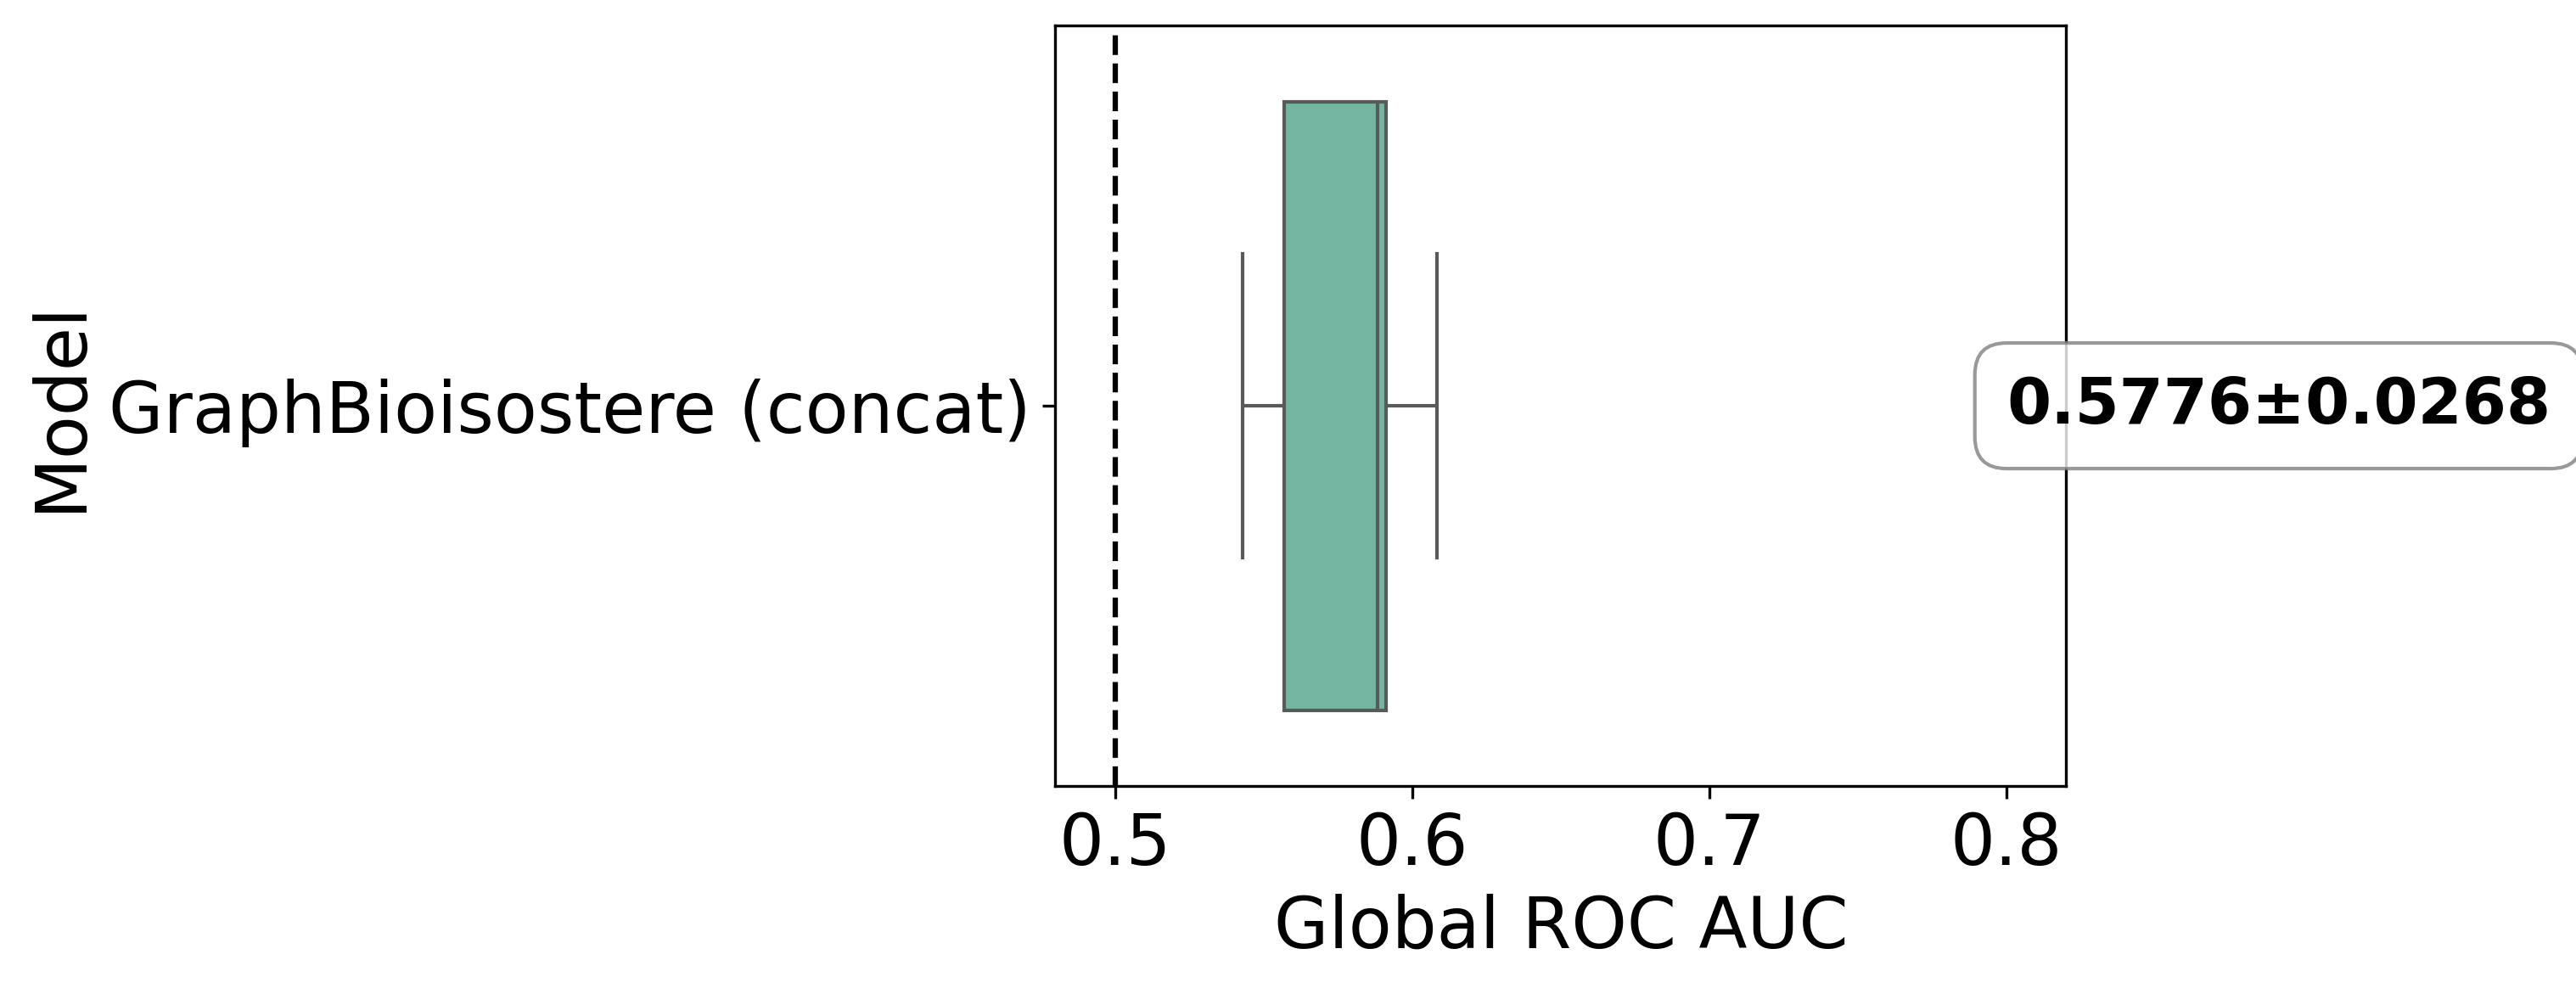


gnn-group-rocauc.png:


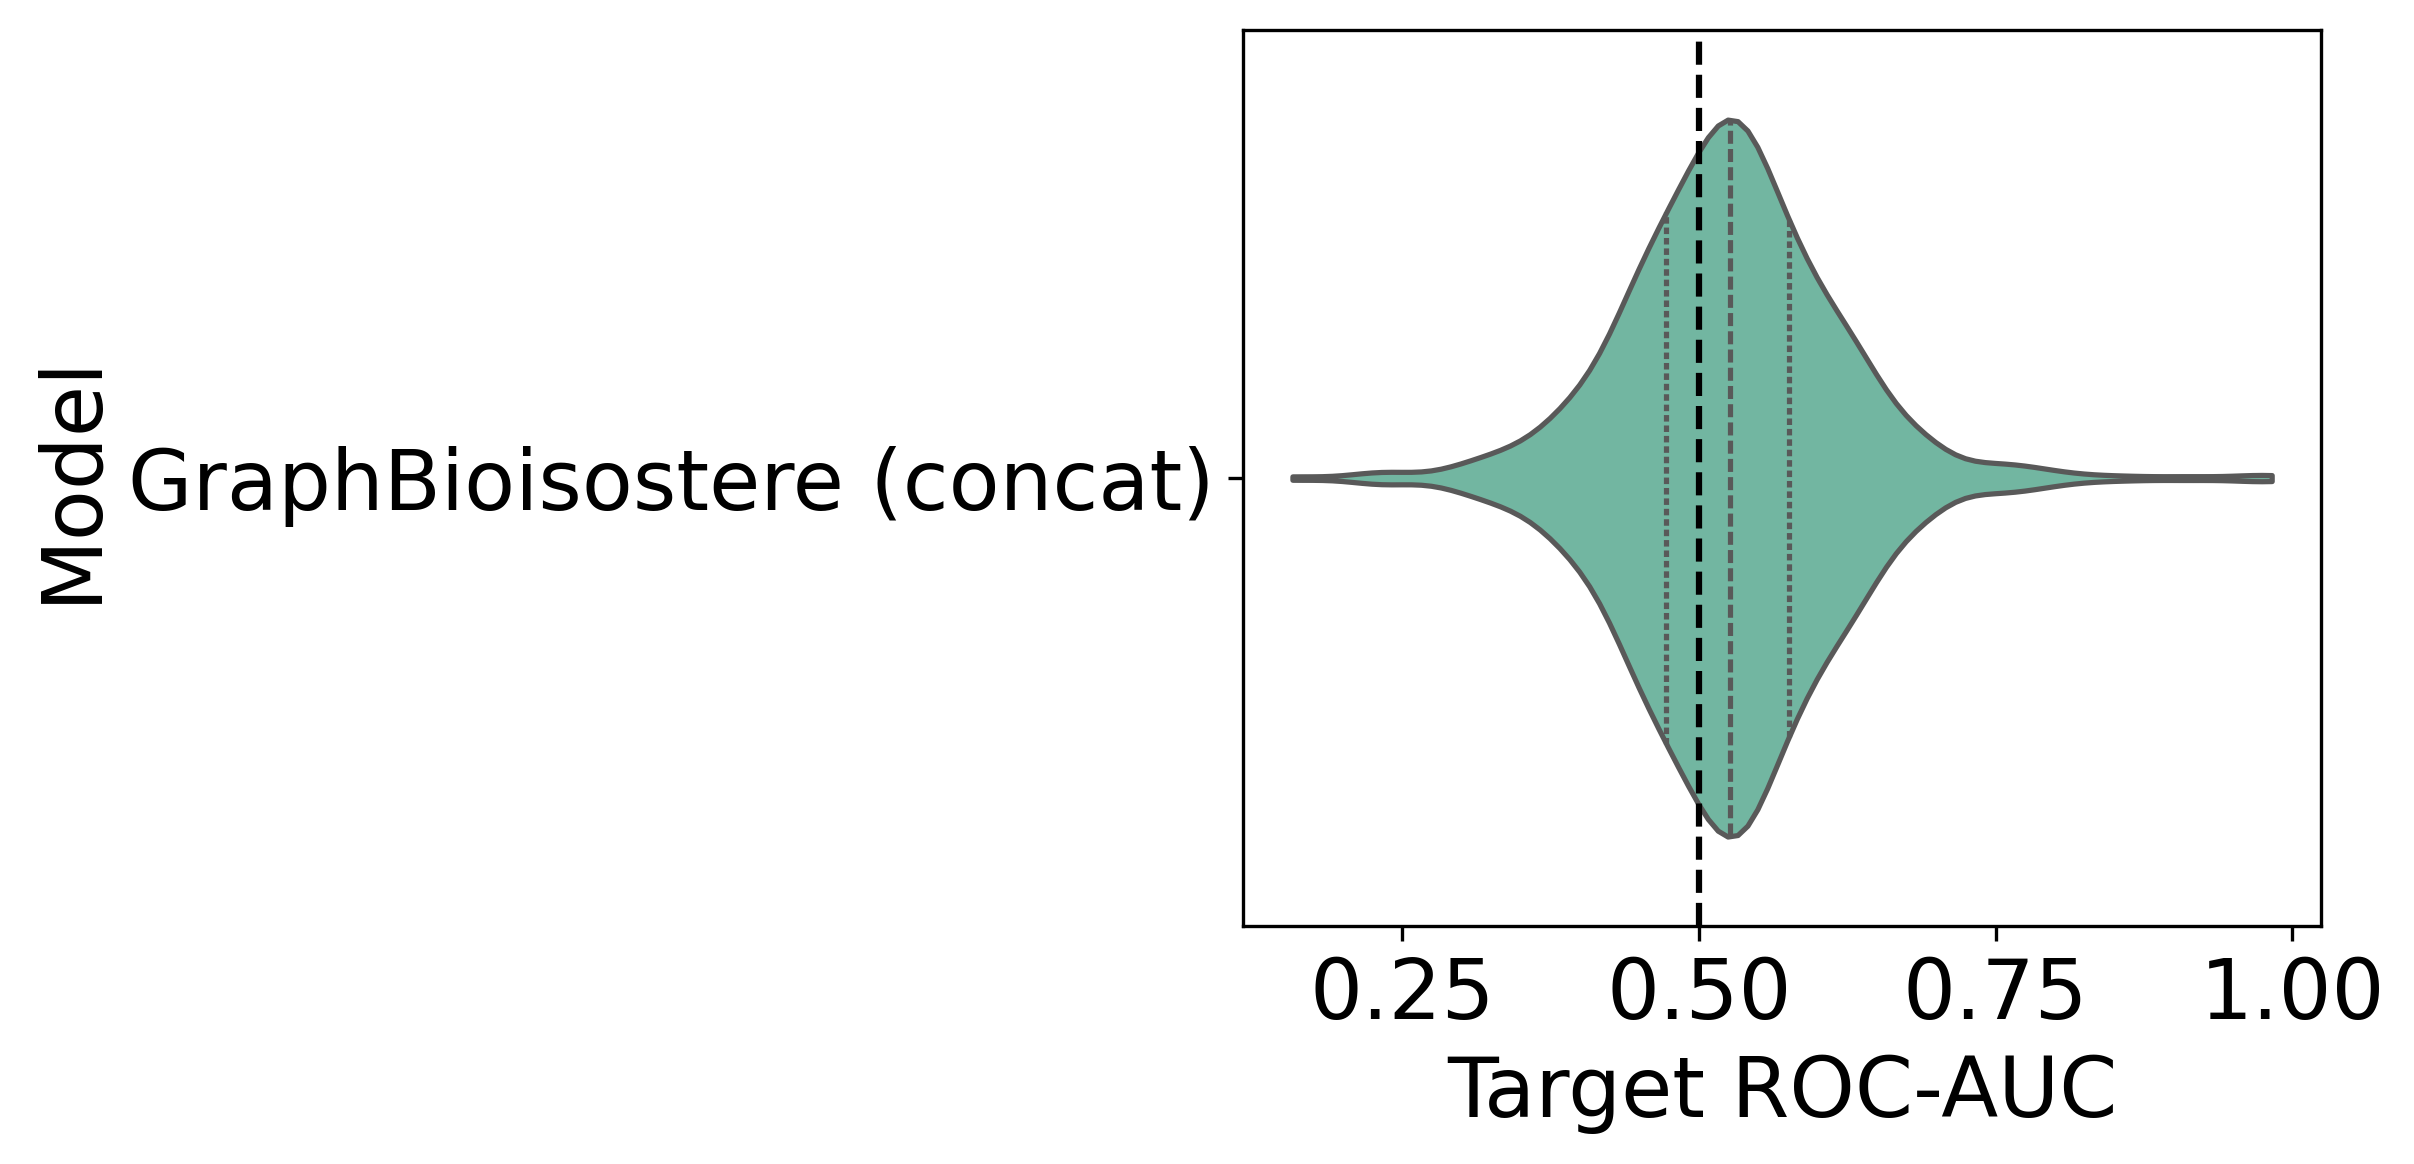


tanimoto_vs_rocauc_5fold.png:


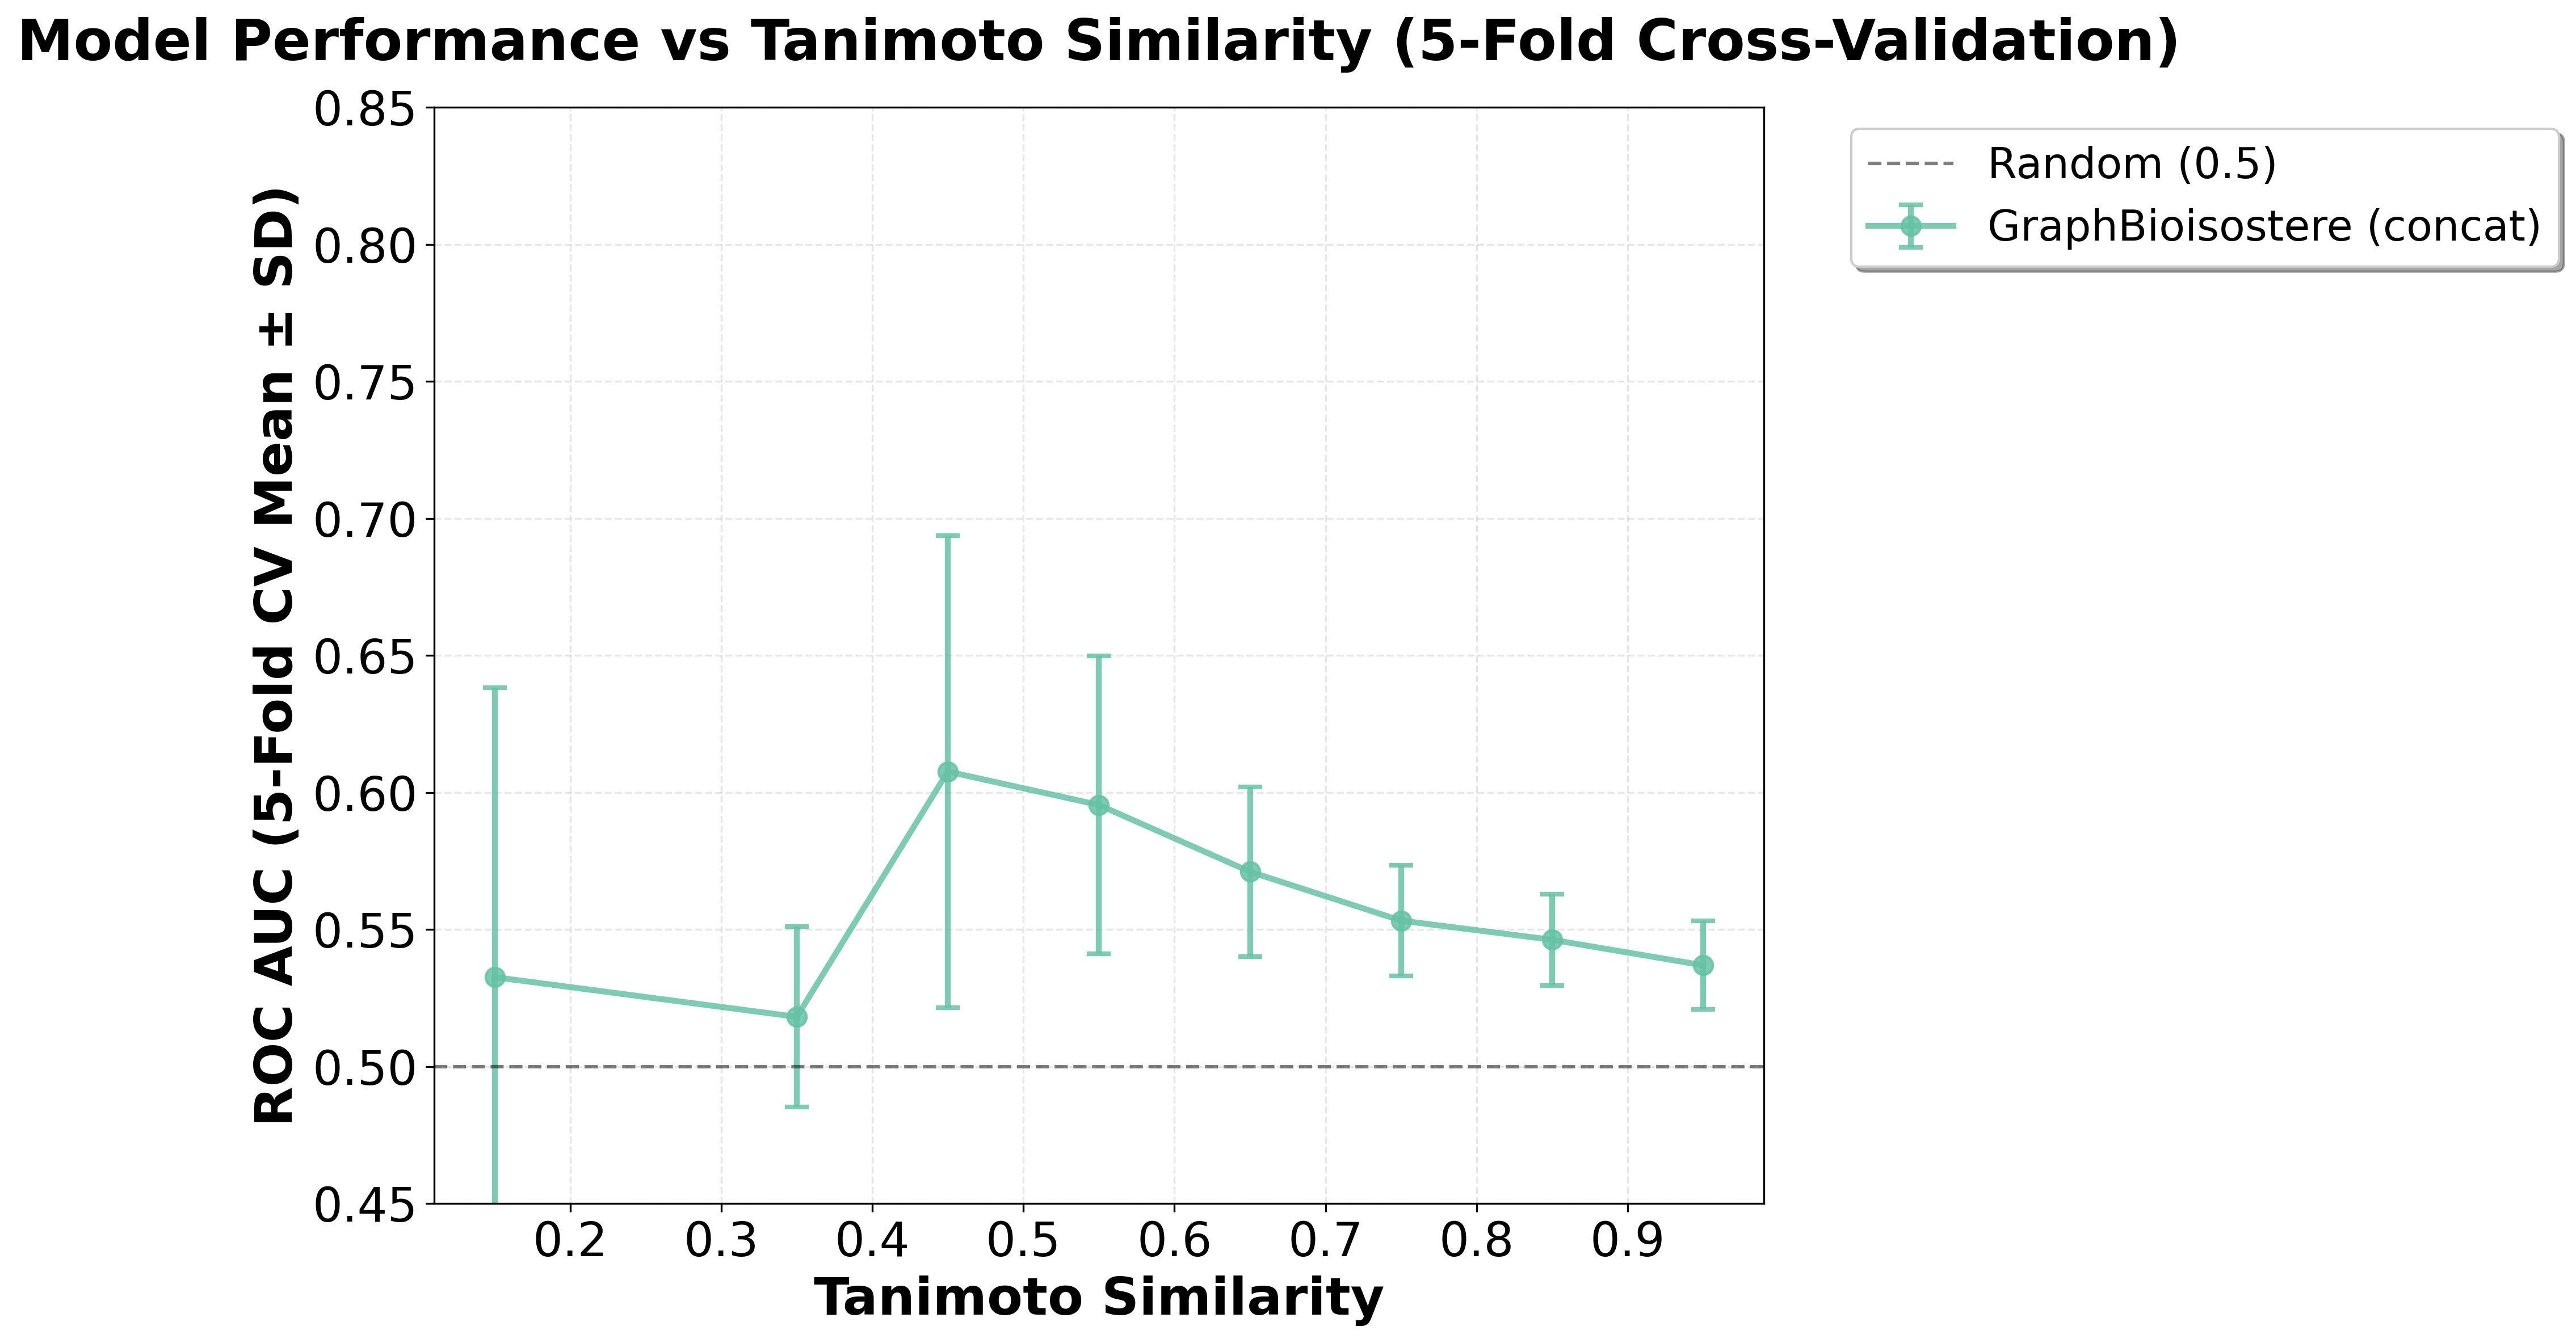


tanimoto_vs_accuracy_5fold.png:


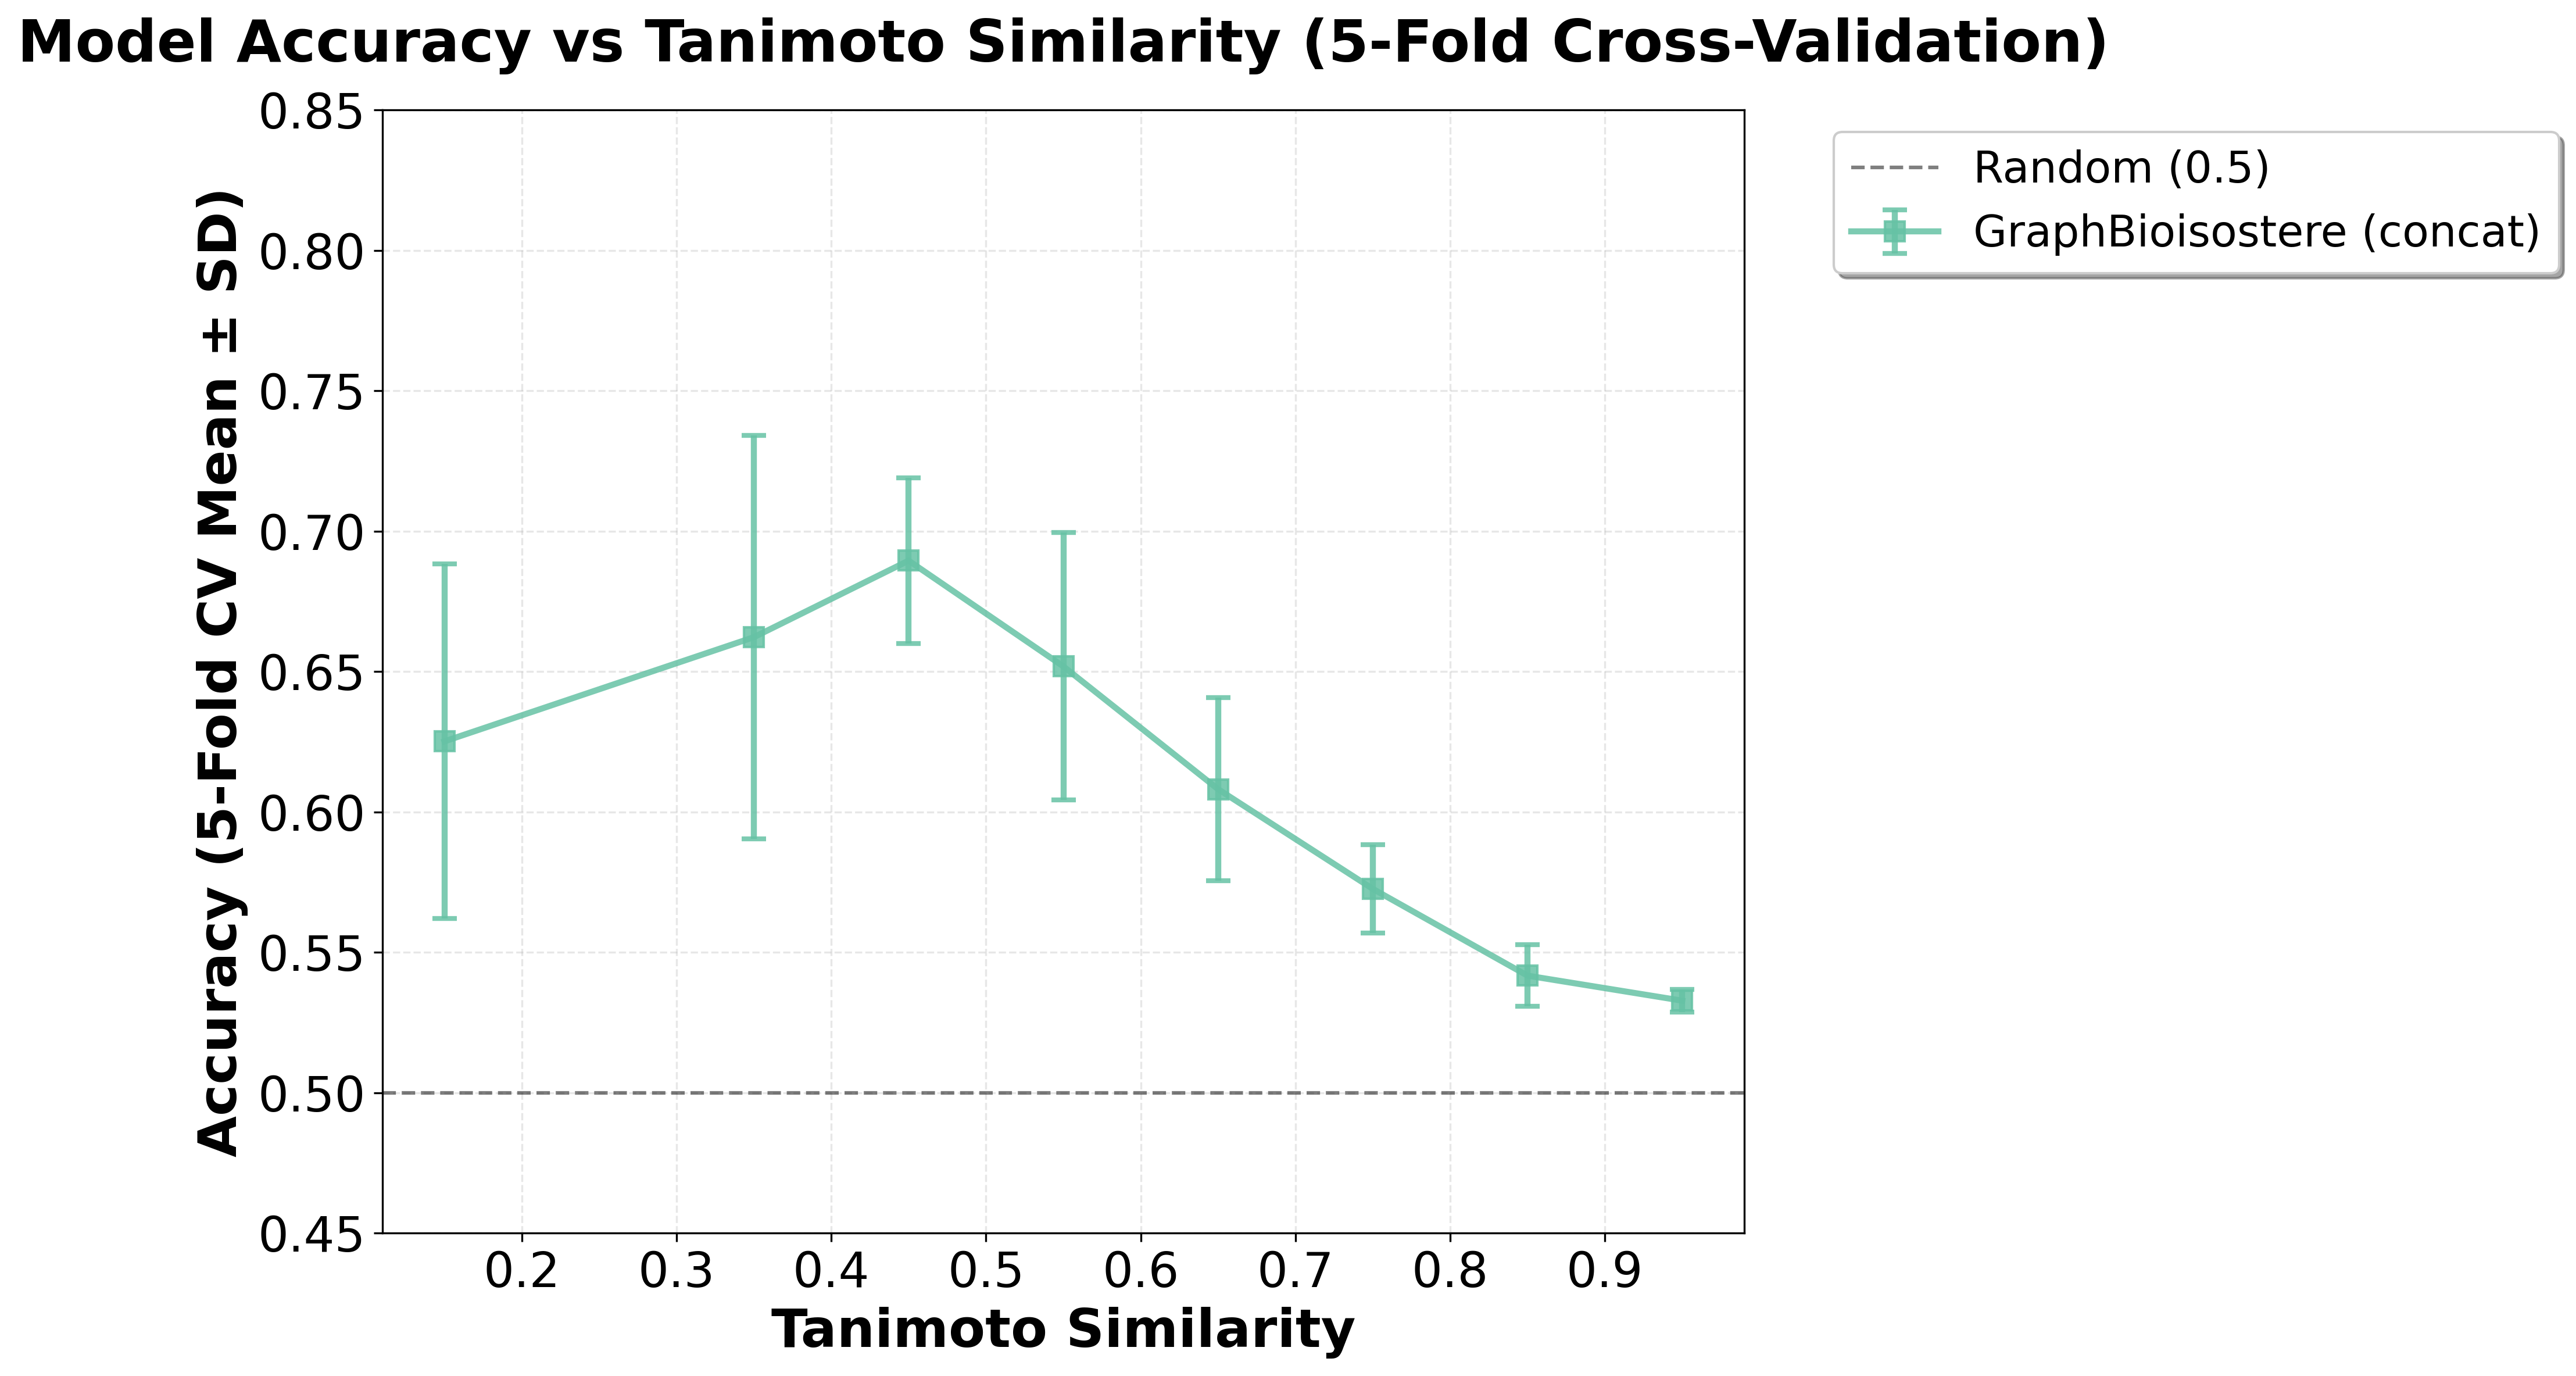


（他の図は /gs/bs/tga-ohuelab/masunaga/bioiso/test/figures_gcn_consistentsmiles ディレクトリで確認してください）


In [ ]:
from IPython.display import Image, display

# 図のファイル名パターン（必要に応じて変更）
figure_patterns = [
    f'*performance*.{figure_format}',
    f'*auc*.{figure_format}',
    f'*accuracy*.{figure_format}',
    f'*comparison*.{figure_format}'
]

print("=== 生成された図の表示 ===")
if analyzer.figures_dir.exists():
    displayed_count = 0
    for pattern in figure_patterns:
        for fig_file in sorted(analyzer.figures_dir.glob(pattern)):
            if figure_format in ['png', 'jpg', 'jpeg', 'gif']:
                print(f"\n{fig_file.name}:")
                display(Image(filename=str(fig_file)))
                displayed_count += 1
                if displayed_count >= 5:  # 最大5枚まで表示
                    break
        if displayed_count >= 5:
            break
    
    if displayed_count == 0:
        print("表示可能な図が見つかりませんでした")
    else:
        print(f"\n（他の図は {analyzer.figures_dir} ディレクトリで確認してください）")
else:
    print("図ディレクトリが存在しません")

## 完了

分析と図の生成が完了しました！

**生成されたファイルの場所:**
- 結果CSV: `{analyzer.results_dir}`
- 図: `{analyzer.figures_dir}`

**使用例:**

1. **デフォルト設定で実行（GNNのみ、統合モード）:**
   - パラメータ設定セルで `gnn_predictions_dirs` と `include_lgbm` をデフォルトのまま実行

2. **特定のpklファイルを指定:**
   - パラメータ設定セルで以下のように設定:
   ```python
   cv_pkl_file = '../splitting/tid_5cv_consistentsmiles.pkl'
   ```
   - または絶対パスで指定:
   ```python
   cv_pkl_file = '/home/8/uf02678/gsbsmasunaga/bioiso/splitting/tid_5cv_frag.pkl'
   ```

3. **LGBMも含めて実行:**
   - パラメータ設定セルで `include_lgbm = True` に変更

4. **特定のGNN予測ディレクトリを指定:**
   - パラメータ設定セルで `gnn_predictions_dirs = ['../pro_GNN/results/results_consistentsmiles']` に変更

5. **Triple版（3グラフ入力）の結果を分析:**
   - パラメータ設定セルで以下のように設定:
   ```python
   gnn_predictions_dirs = ['../pro_GNN/results/results_consistentsmiles_triple']
   cv_pkl_file = '../splitting/tid_5cv_consistentsmiles.pkl'  # 必要に応じて
   ```
   - Triple版では `pair-concat`, `pair-hierarchical` モデルが使用されます（diffは削除されました）

6. **異なる条件（frag vs 通常、または triple vs 通常）を比較:**
   - パラメータ設定セルで以下のように設定:
   ```python
   gnn_predictions_dirs = [
       '../pro_GNN/results/results_consistentsmiles_triple',
       '../pro_GNN/results/results_consistentsmiles'
   ]
   comparison_mode = 'compare'
   cv_pkl_file = '../splitting/tid_5cv_consistentsmiles.pkl'  # 共通のCVファイル
   ```

7. **既存のCSVから図のみ生成:**
   - パラメータ設定セルで `skip_calculation = True` に変更して6番目のセルのみ実行

**cv_pkl_file パラメータについて:**
- `None`（デフォルト）: GNN予測ディレクトリ名から自動的に推測されます
  - 例: `results_consistentsmiles` → `tid_5cv_consistentsmiles.pkl`
  - 例: `results_frag` → `tid_5cv_frag.pkl`
- **相対パス**: `../splitting/tid_5cv_xxx.pkl` のように指定
- **絶対パス**: `/full/path/to/tid_5cv_xxx.pkl` のように指定
- 複数のGNN予測ディレクトリを比較する場合は、共通のCVファイルを指定することを推奨

**comparison_mode について:**
- `'merge'`: 同じモデルの複数フォールド結果を統合してまとめる（デフォルト）
- `'compare'`: 異なる条件の結果を比較する。モデル名に条件識別子が付加されます
  - 例: "GraphBioisostere (concat) [通常]" vs "GraphTriple (concat) [triple]"

**サポートされているモデルタイプ:**
- **2グラフ入力（通常のペア）**: `pair-cat`, `pair-diff`, `pair-product`
- **3グラフ入力（triple - Shared Encoder）**: `pair-concat`, `pair-hierarchical`
- **3グラフ入力（triple - Separate Encoder）**: `pair-separate_common_concat`, `pair-separate_common_hierarchical`

## Tanimoto分析の実行条件確認

Tanimoto類似度別の分析は以下の条件でのみ実行されます：
- ✅ **単一GNN予測ディレクトリ**を指定した場合
- ❌ 複数GNN CSVファイルを直接指定した場合
- ❌ 複数GNN予測ディレクトリを指定した場合
- ❌ CSV直接指定モード

In [ ]:
# 現在の設定でTanimoto分析が実行されるか確認
import importlib
import sys

if 'generate_final_figures' in sys.modules:
    importlib.reload(sys.modules['generate_final_figures'])
from generate_final_figures import BioisosterePredictionAnalyzer

# テスト1: 単一GNN予測ディレクトリ（Tanimoto分析実行される）
test1 = BioisosterePredictionAnalyzer(
    gnn_predictions_dirs=['../pro_GNN/results/results_consistentsmiles']
)
print("=== テスト1: 単一GNN予測ディレクトリ ===")
print(f"  GNN予測ディレクトリ数: {len(test1.gnn_predictions_dirs)}")
print(f"  Tanimoto分析を実行: {test1._should_generate_tanimoto_analysis()}")

# テスト2: 複数GNN予測ディレクトリ（Tanimoto分析スキップ）
test2 = BioisosterePredictionAnalyzer(
    gnn_predictions_dirs=[
        '../pro_GNN/results/results_consistentsmiles',
        '../pro_GNN/results/results_consistentsmiles_frag'
    ]
)
print("\n=== テスト2: 複数GNN予測ディレクトリ ===")
print(f"  GNN予測ディレクトリ数: {len(test2.gnn_predictions_dirs)}")
print(f"  Tanimoto分析を実行: {test2._should_generate_tanimoto_analysis()}")

# テスト3: CSV直接指定（Tanimoto分析スキップ）
test3 = BioisosterePredictionAnalyzer()
test3.gnn_csv_files = [
    Path('../test/results_consistentsmiles/gnn_results_df_single.csv'),
    Path('../test/results_consistentsmiles_frag/gnn_results_df_single.csv')
]
print("\n=== テスト3: 複数CSV直接指定 ===")
print(f"  GNN CSVファイル数: {len(test3.gnn_csv_files)}")
print(f"  Tanimoto分析を実行: {test3._should_generate_tanimoto_analysis()}")

# テスト4: 単一CSV直接指定（Tanimoto分析スキップ）
test4 = BioisosterePredictionAnalyzer()
test4.gnn_csv_files = [
    Path('../test/results_consistentsmiles/gnn_results_df_single.csv')
]
print("\n=== テスト4: 単一CSV直接指定 ===")
print(f"  GNN CSVファイル数: {len(test4.gnn_csv_files)}")
print(f"  Tanimoto分析を実行: {test4._should_generate_tanimoto_analysis()}")

=== テスト1: 単一GNN予測ディレクトリ ===
  GNN予測ディレクトリ数: 1
  Tanimoto分析を実行: True

=== テスト2: 複数GNN予測ディレクトリ ===
  GNN予測ディレクトリ数: 2
  Tanimoto分析を実行: False

=== テスト3: 複数CSV直接指定 ===
  GNN CSVファイル数: 2
  Tanimoto分析を実行: False

=== テスト4: 単一CSV直接指定 ===
  GNN CSVファイル数: 1
  Tanimoto分析を実行: False


### 実際の使用例

#### 例1: 単一GNNで完全な分析（Tanimoto分析あり）

```python
analyzer = BioisosterePredictionAnalyzer(
    gnn_predictions_dirs=['../pro_GNN/results/results_consistentsmiles'],
    include_lgbm=True
)
analyzer.load_data()
analyzer.run_full_analysis()  # Tanimoto分析も実行される
```

#### 例2: 複数GNN + LGBMの統合（Tanimoto分析なし）

```python
# 複数のGNN結果CSVとLGBMを統合
gnn_csv_files = [
    '../test/results_consistentsmiles/gnn_results_df_single.csv',
    '../test/results_consistentsmiles_frag/gnn_results_df_single.csv',
]

# GNN結果を読み込み
gnn_analyzer = BioisosterePredictionAnalyzer()
gnn_analyzer.gnn_csv_files = [Path(f) for f in gnn_csv_files]
gnn_results = gnn_analyzer.load_gnn_from_csv_files()

# LGBM結果を計算
lgbm_analyzer = BioisosterePredictionAnalyzer(include_lgbm=True)
lgbm_analyzer.load_data()
lgbm_results = lgbm_analyzer.calculate_lgbm_results_from_predictions()

# 統合して図を生成（Tanimoto分析はスキップされる）
combined_results = merge_gnn_lgbm_results(gnn_results, lgbm_results)
final_analyzer.generate_figures(combined_results)
```

## 9. CSVファイルから特定モデルを抽出して比較

既存のCSVファイルから特定のモデルだけを抽出して比較図を生成します。

**目的:** 
- smiles版のGraphBioisostere (concat)
- frag版のGraphBioisostere (concat)
- GraphTriple-Separate (hierarchical)

の3つのモデルを比較する図を生成します。

In [ ]:
# CSVファイルから特定モデルを抽出する設定

# 比較したいCSVファイルとモデル名のマッピング
model_extraction_config = [
    {
        'csv_path': 'results_consistentsmiles/gnn_results_df_single.csv',
        'model_pattern': 'pair-cat',  # モデル列の値（exactマッチ）
        'label': 'SMILES GraphBioisostere (concat)'
    },
    {
        'csv_path': 'results_consistentsmiles_frag/gnn_results_df_single.csv',
        'model_pattern': 'pair-cat',
        'label': 'Frag GraphBioisostere (concat)'
    },
    {
        'csv_path': 'results_consistentsmiles_triple/gnn_results_df_single.csv',
        'model_pattern': 'pair-separate_common_hierarchical',  # triple版のSeparate Encoder
        'label': 'GraphTriple-Separate (hierarchical)'
    }
]

# 出力先ディレクトリ
comparison_output_dir = Path('./results_model_comparison')
comparison_figures_dir = Path('./figures_model_comparison')

print("=== モデル比較設定 ===")
for i, config in enumerate(model_extraction_config, 1):
    print(f"{i}. {config['label']}")
    print(f"   CSV: {config['csv_path']}")
    print(f"   モデル: {config['model_pattern']}")
print(f"\n出力先:")
print(f"  結果CSV: {comparison_output_dir}")
print(f"  図: {comparison_figures_dir}")

=== モデル比較設定 ===
1. SMILES GraphBioisostere (concat)
   CSV: results_consistentsmiles/gnn_results_df_single.csv
   モデル: pair-cat
2. Frag GraphBioisostere (concat)
   CSV: results_consistentsmiles_frag/gnn_results_df_single.csv
   モデル: pair-cat
3. GraphTriple-Separate (hierarchical)
   CSV: results_consistentsmiles_triple/gnn_results_df_single.csv
   モデル: pair-separate_common_hierarchical

出力先:
  結果CSV: results_model_comparison
  図: figures_model_comparison


In [ ]:
# CSVファイルから特定モデルを抽出する関数（箱ひげ図用に全フォールドデータを保持）
import re

def extract_models_for_boxplot(config_list, base_dir=None):
    """
    複数のCSVファイルから特定のモデルだけを抽出し、箱ひげ図用に全フォールドのデータを保持
    
    Parameters:
    -----------
    config_list : list of dict
        各要素は以下のキーを持つ辞書:
        - 'csv_path': CSVファイルのパス
        - 'model_pattern': 抽出したいモデルの値（'model'列）
        - 'label': 結果に付けるラベル
    base_dir : Path or None
        ベースディレクトリ（Noneの場合は現在のディレクトリの親）
    
    Returns:
    --------
    pd.DataFrame
        抽出されたモデルの全フォールドデータ（箱ひげ図用）
    """
    if base_dir is None:
        base_dir = Path.cwd().parent
    else:
        base_dir = Path(base_dir)
    
    all_results = []
    
    for config in config_list:
        csv_path = base_dir / config['csv_path']
        model_pattern = config['model_pattern']
        label = config['label']
        
        print(f"\n処理中: {csv_path}")
        
        if not csv_path.exists():
            print(f"  ⚠️ ファイルが見つかりません: {csv_path}")
            continue
        
        # CSVを読み込み
        df = pd.read_csv(csv_path)
        print(f"  読み込み: {len(df)} 行")
        
        # モデル列を確認（'model'または'Model'）
        model_col = 'model' if 'model' in df.columns else 'Model' if 'Model' in df.columns else None
        
        if model_col is None:
            print(f"  ⚠️ モデル列が見つかりません")
            continue
        
        # モデルでフィルタリング
        filtered_df = df[df[model_col] == model_pattern].copy()
        
        if len(filtered_df) == 0:
            print(f"  ⚠️ モデル '{model_pattern}' が見つかりません")
            print(f"  利用可能なモデル: {df[model_col].unique()}")
            continue
        
        print(f"  抽出: {len(filtered_df)} 行（{len(filtered_df)} フォールド）")
        
        # 比較用のラベルを追加
        filtered_df['comparison_label'] = label
        filtered_df['model_id'] = model_pattern
        
        all_results.append(filtered_df)
        
        print(f"  ✅ 抽出完了: {len(filtered_df)} フォールド")
    
    if not all_results:
        raise ValueError("抽出されたデータがありません")
    
    # 全データを結合
    result_df = pd.concat(all_results, ignore_index=True)
    
    print(f"\n=== 抽出結果 ===")
    print(f"総行数: {len(result_df)}")
    print(f"比較ラベル: {result_df['comparison_label'].unique().tolist()}")
    print(f"列: {result_df.columns.tolist()}")
    
    return result_df

print("関数定義完了: extract_models_for_boxplot（箱ひげ図用）")

関数定義完了: extract_models_for_boxplot（箱ひげ図用）


In [ ]:
# CSVファイルから特定モデルを抽出（箱ひげ図用に全フォールドデータを保持）
try:
    comparison_data_full = extract_models_for_boxplot(
        model_extraction_config,
        base_dir=Path.cwd().parent / 'test'
    )
    
    # 出力ディレクトリを作成
    comparison_output_dir.mkdir(exist_ok=True)
    comparison_figures_dir.mkdir(exist_ok=True)
    
    # 全フォールドデータを保存
    output_csv = comparison_output_dir / 'comparison_models_full_data.csv'
    comparison_data_full.to_csv(output_csv, index=False)
    print(f"\n✅ 全フォールドデータを保存: {output_csv}")
    
    # データの概要を表示
    print("\n=== データサンプル（先頭5行）===")
    display(comparison_data_full[['comparison_label', 'fold', 'global_roc_auc', 
                                   'accuracy', 'precision', 'recall', 'f1', 'mcc']].head(5))
    
    print(f"\n総行数: {len(comparison_data_full)}")
    print(f"比較ラベル: {comparison_data_full['comparison_label'].unique().tolist()}")
    
except Exception as e:
    print(f"❌ エラー: {e}")
    import traceback
    traceback.print_exc()


処理中: /gs/bs/tga-ohuelab/masunaga/bioiso/test/results_consistentsmiles/gnn_results_df_single.csv
  読み込み: 15 行
  抽出: 5 行（5 フォールド）
  ✅ 抽出完了: 5 フォールド

処理中: /gs/bs/tga-ohuelab/masunaga/bioiso/test/results_consistentsmiles_frag/gnn_results_df_single.csv
  ⚠️ ファイルが見つかりません: /gs/bs/tga-ohuelab/masunaga/bioiso/test/results_consistentsmiles_frag/gnn_results_df_single.csv

処理中: /gs/bs/tga-ohuelab/masunaga/bioiso/test/results_consistentsmiles_triple/gnn_results_df_single.csv
  ⚠️ ファイルが見つかりません: /gs/bs/tga-ohuelab/masunaga/bioiso/test/results_consistentsmiles_triple/gnn_results_df_single.csv

=== 抽出結果 ===
総行数: 5
比較ラベル: ['SMILES GraphBioisostere (concat)']
列: ['global_roc_auc', 'accuracy', 'precision', 'recall', 'f1', 'mcc', 'mean_group_count', 'mean_positive_count', 'mean_negative_count', 'mean_group_accuracy', 'mean_group_precision', 'mean_group_recall', 'mean_group_f1', 'mean_group_auc', 'fold', 'model', 'Model', 'comparison_label', 'model_id']

✅ 全フォールドデータを保存: results_model_comparison/comparison_

,comparison_label,fold,global_roc_auc,accuracy,precision,recall,f1,mcc
0,SMILES GraphBioisostere (concat),0,0.596220,0.603144,0.563769,0.351818,0.433261,0.162447
1,SMILES GraphBioisostere (concat),1,0.593152,0.646906,0.481678,0.291702,0.363357,0.147371
2,SMILES GraphBioisostere (concat),2,0.548807,0.611963,0.454918,0.130672,0.203026,0.055202
3,SMILES GraphBioisostere (concat),3,0.612019,0.628402,0.674684,0.264766,0.380294,0.222257
4,SMILES GraphBioisostere (concat),4,0.529079,0.565187,0.465359,0.174731,0.254066,0.036594



総行数: 5
比較ラベル: ['SMILES GraphBioisostere (concat)']


In [ ]:
# 比較図を生成する関数（箱ひげ図版 - generate_final_figures.pyのスタイルに準拠）

def generate_boxplot_comparison_figures(full_data_df, output_dir, figure_format='png'):
    """
    全フォールドデータから箱ひげ図を生成（generate_final_figures.pyのスタイルに準拠）
    平均値±標準偏差を図の隣に表示
    
    Parameters:
    -----------
    full_data_df : pd.DataFrame
        全フォールドのデータ（各行が1つのフォールドの結果）
    output_dir : Path
        図の出力先ディレクトリ
    figure_format : str
        図の保存形式
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # フォントサイズの設定（元のスクリプトに合わせる）
    fontsize = 14
    
    # ユニークなラベルを取得してソート
    labels = full_data_df['comparison_label'].unique().tolist()
    
    print(f"\n=== データ概要 ===")
    print(f"比較ラベル: {labels}")
    print(f"総フォールド数: {len(full_data_df)}")
    for label in labels:
        count = len(full_data_df[full_data_df['comparison_label'] == label])
        print(f"  {label}: {count} フォールド")
    
    # 全メトリクスの統計情報を事前計算
    stats_summary = full_data_df.groupby('comparison_label').agg({
        'global_roc_auc': ['mean', 'std'],
        'accuracy': ['mean', 'std'],
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'f1': ['mean', 'std'],
        'mcc': ['mean', 'std']
    })
    
    # データの統計情報を表示
    print("\n=== 統計情報 ===")
    stats_df = full_data_df.groupby('comparison_label').agg({
        'global_roc_auc': ['mean', 'std', 'count'],
        'accuracy': ['mean', 'std'],
        'f1': ['mean', 'std'],
        'mcc': ['mean', 'std']
    }).round(4)
    display(stats_df)
    
    # 図1: AUC箱ひげ図（横向き）- 元のスタイルに準拠 + 平均値±標準偏差表示
    fig_height = max(4, len(labels) * 0.8)
    fig, ax = plt.subplots(figsize=(10, fig_height))
    
    # 箱ひげ図（横向き、元のスタイルに合わせる）
    sns.boxplot(data=full_data_df, y="comparison_label", x="global_roc_auc",
               hue="comparison_label", palette="Set2", ax=ax, order=labels, legend=False)
    
    # 平均値±標準偏差を各箱ひげ図の右側に表示
    for i, label in enumerate(labels):
        mean_val = stats_summary.loc[label, ('global_roc_auc', 'mean')]
        std_val = stats_summary.loc[label, ('global_roc_auc', 'std')]
        ax.text(0.73, i, f'{mean_val:.4f}±{std_val:.4f}',
               va='center', fontsize=fontsize-2, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray', alpha=0.8))
    
    # 基準線（0.5）
    ax.axvline(0.5, linestyle="--", color="black", linewidth=1.5)
    
    ax.set_ylabel('Model', fontsize=fontsize, fontweight='bold')
    ax.set_xlabel('Global ROC AUC', fontsize=fontsize, fontweight='bold')
    ax.set_xlim([0.48, 0.78])  # 右側に余裕を持たせる
    ax.set_ylim([-0.5, len(labels)-0.5])
    ax.tick_params(labelsize=fontsize)
    
    plt.tight_layout()
    fig_path = output_dir / f'model_comparison_auc_boxplot.{figure_format}'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ 保存: {fig_path}")
    plt.show()
    plt.close()
    
    # 図2: 各メトリクスの横向き箱ひげ図 + 平均値±標準偏差表示
    fig, axes = plt.subplots(2, 3, figsize=(18, max(8, len(labels) * 1.2)))
    fig.suptitle('Model Performance Comparison (Boxplots across folds)', 
                 fontsize=16, fontweight='bold')
    
    metric_pairs = [
        ('global_roc_auc', 'Global ROC AUC', [0.48, 0.78]),
        ('accuracy', 'Accuracy', [0.0, 1.05]),
        ('precision', 'Precision', [0.0, 1.05]),
        ('recall', 'Recall', [0.0, 1.05]),
        ('f1', 'F1 Score', [0.0, 1.05]),
        ('mcc', 'MCC', [-0.1, 0.55])
    ]
    
    for idx, (metric_col, metric_label, xlim) in enumerate(metric_pairs):
        ax = axes[idx // 3, idx % 3]
        
        # 横向き箱ひげ図
        sns.boxplot(data=full_data_df, y="comparison_label", x=metric_col,
                   hue="comparison_label", palette="Set2", ax=ax, order=labels, legend=False)
        
        # 平均値±標準偏差を各箱ひげ図の右側に表示
        x_offset = xlim[1] * 0.85  # 右側に配置
        for i, label in enumerate(labels):
            mean_val = stats_summary.loc[label, (metric_col, 'mean')]
            std_val = stats_summary.loc[label, (metric_col, 'std')]
            ax.text(x_offset, i, f'{mean_val:.3f}±{std_val:.3f}',
                   va='center', fontsize=fontsize-4, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
        
        # 基準線（MCC以外は0.5、MCCは0）
        if metric_col != 'mcc':
            ax.axvline(0.5, linestyle="--", color="black", linewidth=1)
        else:
            ax.axvline(0.0, linestyle="--", color="black", linewidth=1)
        
        ax.set_ylabel('', fontsize=fontsize-2)
        ax.set_xlabel(metric_label, fontsize=fontsize-1, fontweight='bold')
        ax.set_xlim(xlim)
        ax.set_ylim([-0.5, len(labels)-0.5])
        ax.tick_params(labelsize=fontsize-3)
    
    plt.tight_layout()
    fig_path = output_dir / f'model_comparison_metrics_boxplot.{figure_format}'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ 保存: {fig_path}")
    plt.show()
    plt.close()
    
    # 図3: 全メトリクスのレーダーチャート（平均値のみ）
    from math import pi
    
    # 平均値を計算
    metrics_summary = full_data_df.groupby('comparison_label').agg({
        'global_roc_auc': 'mean',
        'accuracy': 'mean',
        'precision': 'mean',
        'recall': 'mean',
        'f1': 'mean',
        'mcc': 'mean'
    })
    
    categories = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'MCC']
    metric_cols = ['global_roc_auc', 'accuracy', 'precision', 'recall', 'f1', 'mcc']
    N = len(categories)
    
    colors = sns.color_palette("Set2", len(labels))
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=fontsize, fontweight='bold')
    ax.set_ylim(0, 1)
    
    for idx, label in enumerate(labels):
        values = metrics_summary.loc[label, metric_cols].values.tolist()
        # MCCを正規化（-1~1を0~1に）
        values[-1] = (values[-1] + 1) / 2
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2.5, label=label, 
                color=colors[idx], markersize=8)
        ax.fill(angles, values, alpha=0.15, color=colors[idx])
    
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=fontsize-2)
    ax.set_title('Performance Radar Chart (Mean Values)', size=16, fontweight='bold', pad=20)
    ax.grid(True)
    
    plt.tight_layout()
    fig_path = output_dir / f'model_comparison_radar.{figure_format}'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ 保存: {fig_path}")
    plt.show()
    plt.close()
    
    # 図4: メトリクス比較表（ヒートマップ - 平均値）
    fig, ax = plt.subplots(figsize=(12, max(4, len(labels) * 0.8)))
    
    # 表示用データを準備（平均値）
    display_data = metrics_summary[metric_cols].values
    # MCCを正規化
    display_data[:, -1] = (display_data[:, -1] + 1) / 2
    
    im = ax.imshow(display_data.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(categories)))
    ax.set_xticklabels(labels, rotation=15, ha='right', fontsize=fontsize-2)
    ax.set_yticklabels(categories, fontsize=fontsize)
    
    # 値を表示
    for i in range(len(categories)):
        for j in range(len(labels)):
            original_value = metrics_summary.iloc[j][metric_cols[i]]
            text = ax.text(j, i, f'{original_value:.3f}',
                          ha="center", va="center", color="black", 
                          fontweight='bold', fontsize=fontsize-2)
    
    ax.set_title('Performance Heatmap (Mean Values)', fontsize=16, fontweight='bold')
    cbar = fig.colorbar(im, ax=ax, label='Normalized Score')
    cbar.ax.tick_params(labelsize=fontsize-2)
    
    plt.tight_layout()
    fig_path = output_dir / f'model_comparison_heatmap.{figure_format}'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ 保存: {fig_path}")
    plt.show()
    plt.close()
    
    # 図5: Violinplot版（オプション、元のスクリプトで使用されているスタイル）+ 平均値±標準偏差表示
    fig_height = max(4, len(labels) * 0.8)
    fig, ax = plt.subplots(figsize=(10, fig_height))
    
    sns.violinplot(data=full_data_df, y="comparison_label", x="global_roc_auc",
                  hue="comparison_label", ax=ax, order=labels, cut=0, inner="quartile", 
                  palette="Set2", legend=False)
    
    # 平均値±標準偏差を各violinplotの右側に表示
    for i, label in enumerate(labels):
        mean_val = stats_summary.loc[label, ('global_roc_auc', 'mean')]
        std_val = stats_summary.loc[label, ('global_roc_auc', 'std')]
        ax.text(0.73, i, f'{mean_val:.4f}±{std_val:.4f}',
               va='center', fontsize=fontsize-2, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray', alpha=0.8))
    
    ax.axvline(0.5, linestyle="--", color="black", linewidth=1.5)
    
    ax.set_ylabel('Model', fontsize=fontsize, fontweight='bold')
    ax.set_xlabel('Global ROC AUC', fontsize=fontsize, fontweight='bold')
    ax.set_xlim([0.48, 0.78])  # 右側に余裕を持たせる
    ax.set_ylim([-0.5, len(labels)-0.5])
    ax.tick_params(labelsize=fontsize)
    
    plt.tight_layout()
    fig_path = output_dir / f'model_comparison_auc_violinplot.{figure_format}'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ 保存: {fig_path}")
    plt.show()
    plt.close()
    
    print(f"\n✅ 全ての図の生成が完了しました！")
    
    return metrics_summary

print("関数定義完了: generate_boxplot_comparison_figures（箱ひげ図版 + 平均値±標準偏差表示）")

関数定義完了: generate_boxplot_comparison_figures（箱ひげ図版 + 平均値±標準偏差表示）


=== 箱ひげ図を生成中 ===

=== データ概要 ===
比較ラベル: ['SMILES GraphBioisostere (concat)']
総フォールド数: 5
  SMILES GraphBioisostere (concat): 5 フォールド

=== 統計情報 ===


global_roc_auc               accuracy  \
                                           mean     std count     mean   
comparison_label                                                         
SMILES GraphBioisostere (concat)         0.5759  0.0351     5   0.6111   

                                              f1             mcc          
                                     std    mean     std    mean     std  
comparison_label                                                          
SMILES GraphBioisostere (concat)  0.0306  0.3268  0.0951  0.1248  0.0775


✅ 保存: figures_model_comparison/model_comparison_auc_boxplot.png


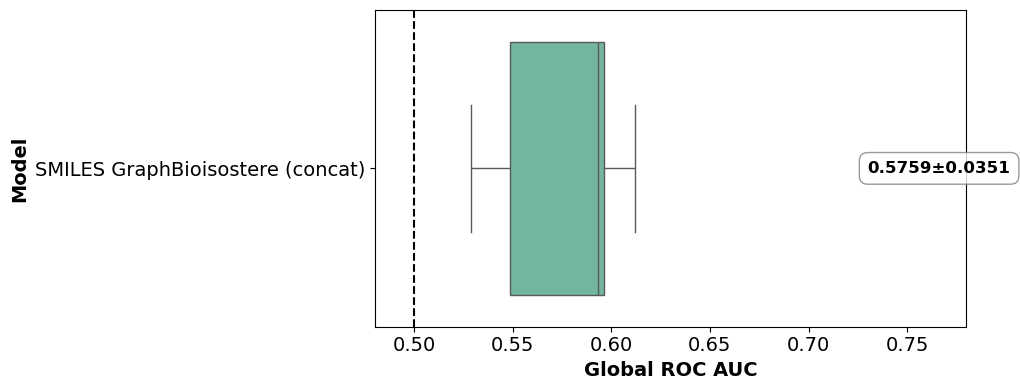

✅ 保存: figures_model_comparison/model_comparison_metrics_boxplot.png


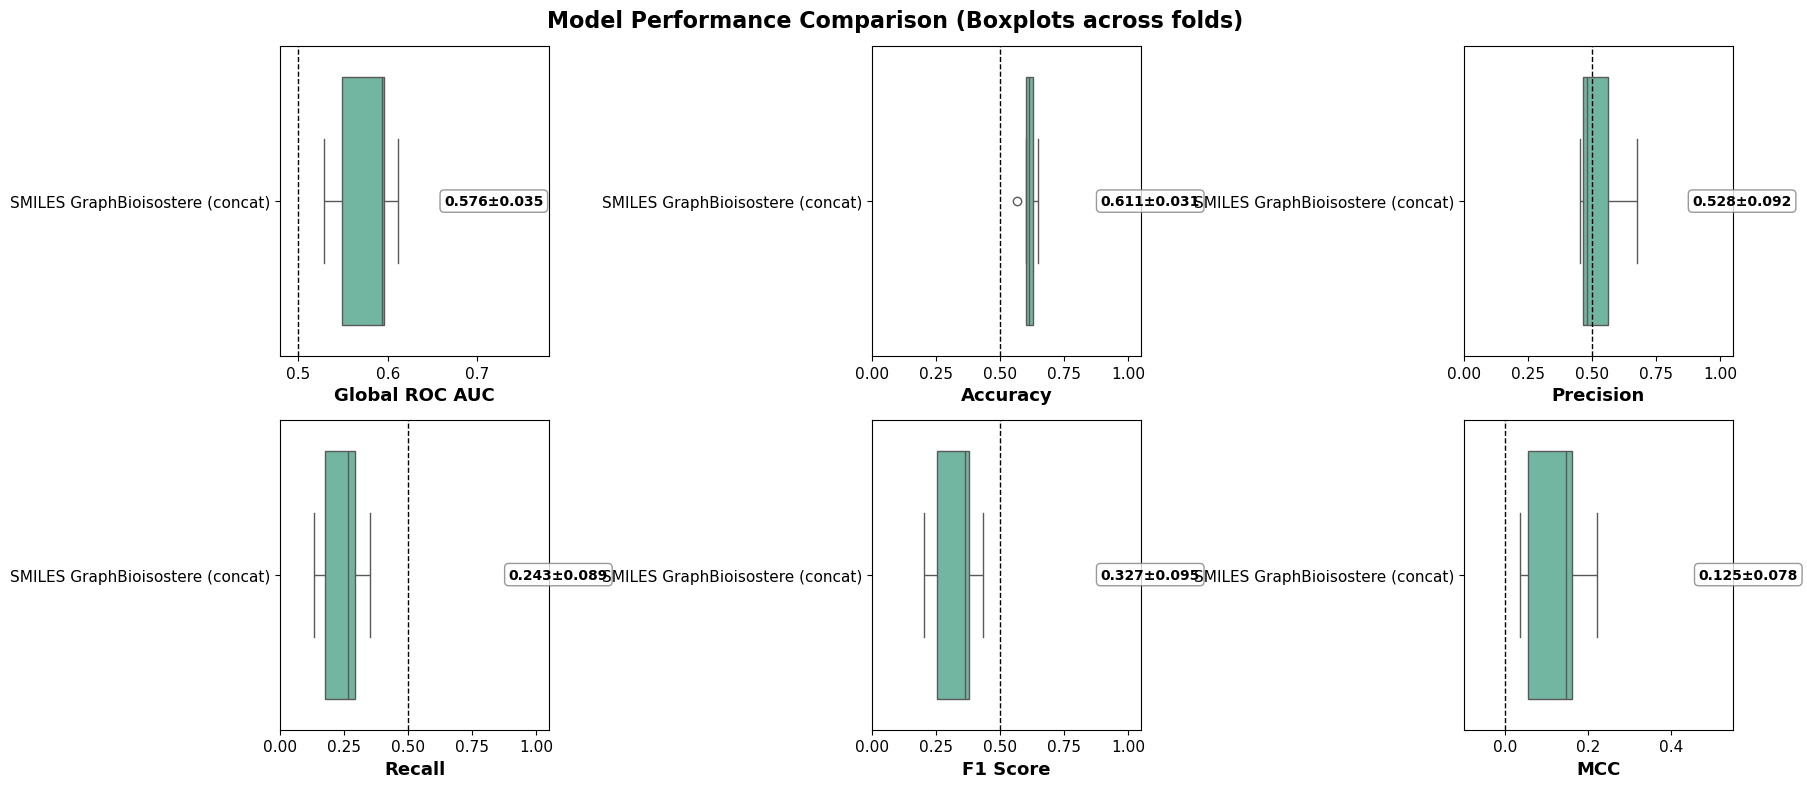

✅ 保存: figures_model_comparison/model_comparison_radar.png


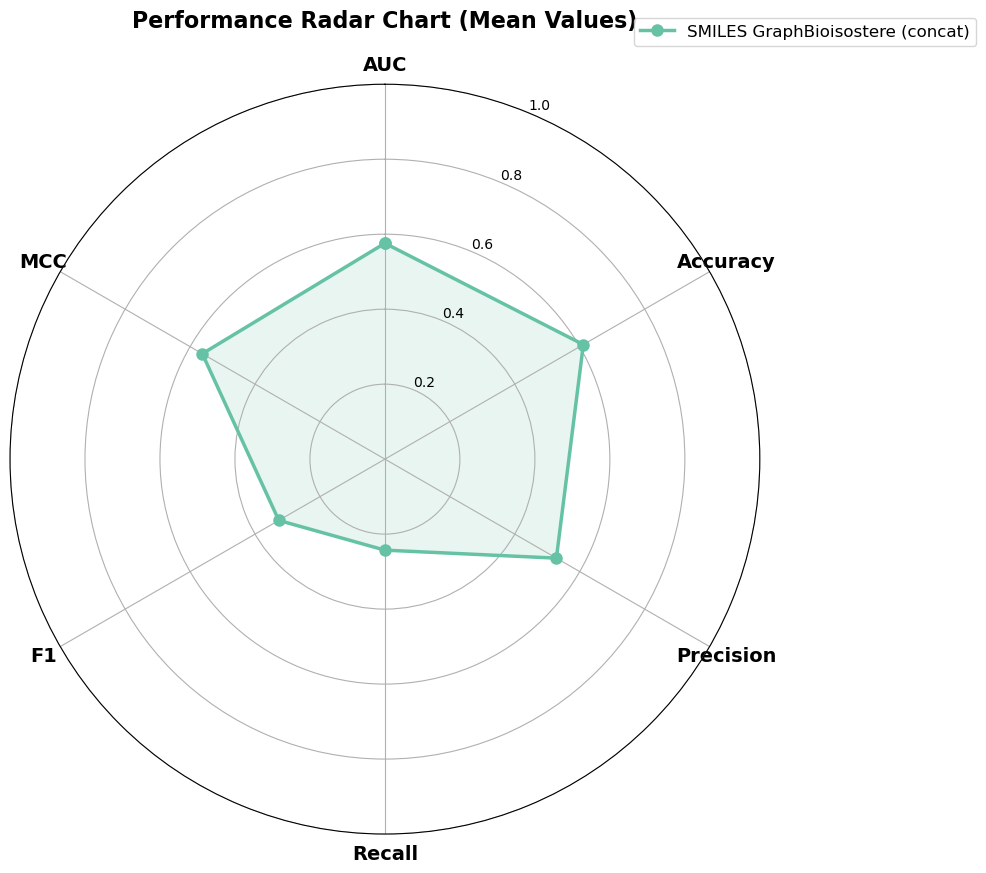

✅ 保存: figures_model_comparison/model_comparison_heatmap.png


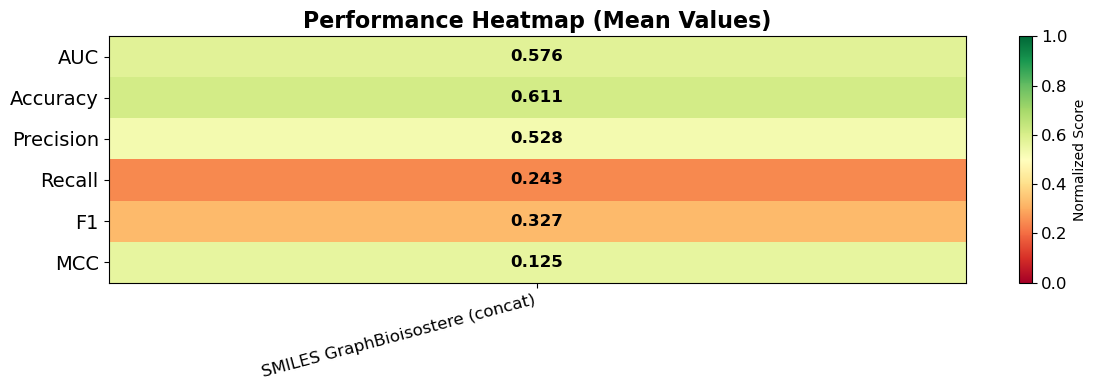

✅ 保存: figures_model_comparison/model_comparison_auc_violinplot.png


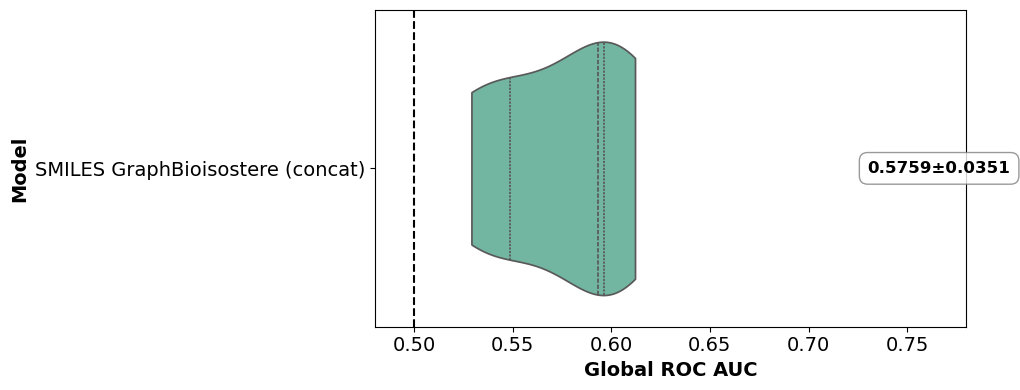


✅ 全ての図の生成が完了しました！

✅ 箱ひげ図の生成が完了しました！
図の保存先: figures_model_comparison

=== 統計サマリー（平均値）===


,global_roc_auc,accuracy,precision,recall,f1,mcc
comparison_label,,,,,,
SMILES GraphBioisostere (concat),0.575855,0.61112,0.528082,0.242738,0.326801,0.124774


In [ ]:
# 箱ひげ図を生成
try:
    if 'comparison_data_full' in locals():
        print("=== 箱ひげ図を生成中 ===")
        metrics_summary = generate_boxplot_comparison_figures(
            comparison_data_full,
            comparison_figures_dir,
            figure_format=figure_format
        )
        
        print("\n✅ 箱ひげ図の生成が完了しました！")
        print(f"図の保存先: {comparison_figures_dir}")
        
        # 統計サマリーの表示
        print("\n=== 統計サマリー（平均値）===")
        display(metrics_summary)
    else:
        print("❌ comparison_data_full が見つかりません。前のセル（31番目）を先に実行してください。")
        
except Exception as e:
    print(f"❌ エラー: {e}")
    import traceback
    traceback.print_exc()

=== 生成された比較図 ===

model_comparison_auc_boxplot.png:


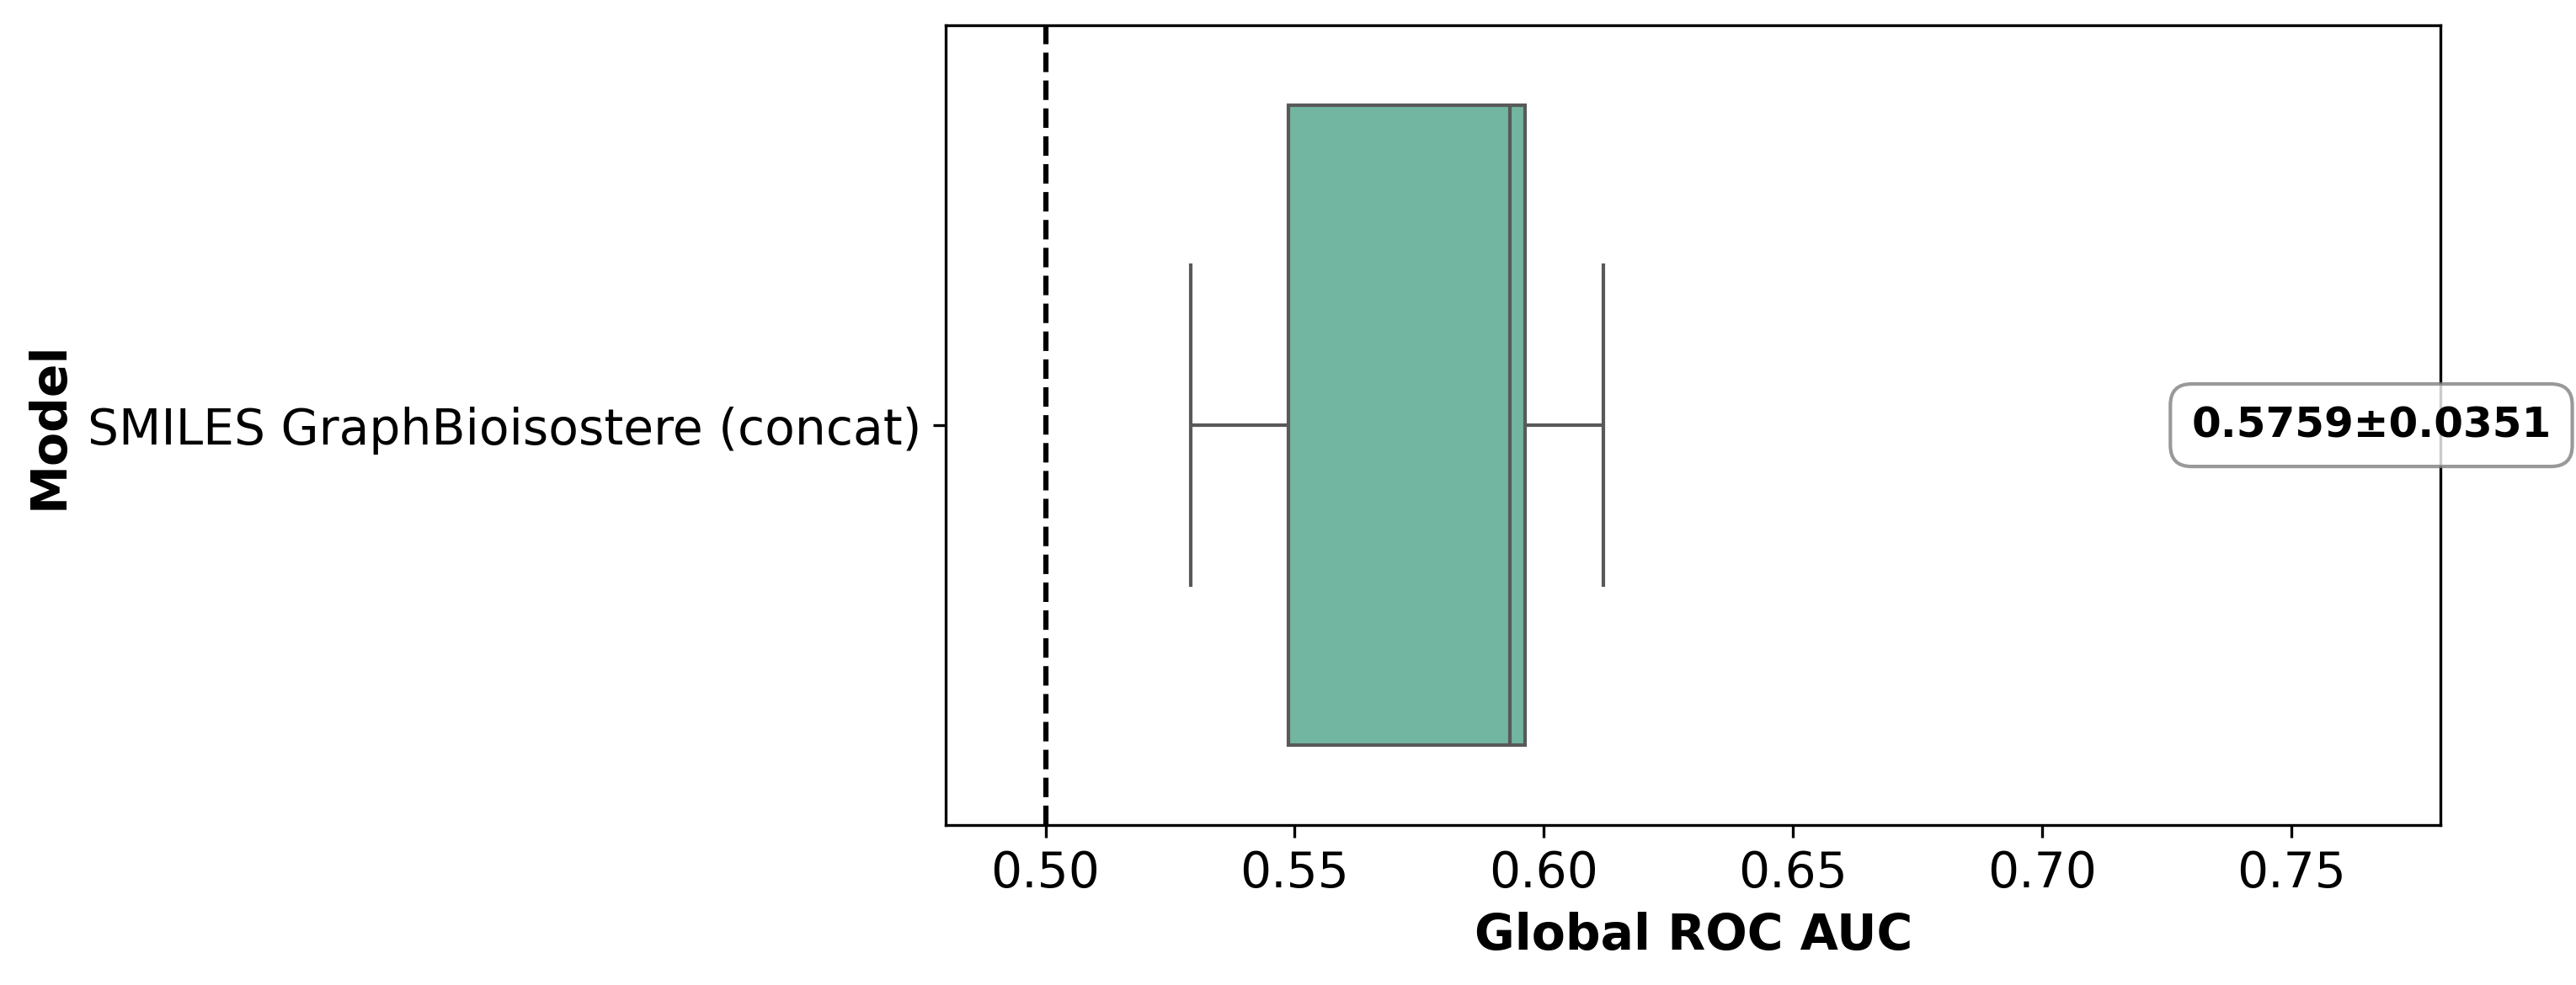


model_comparison_auc_violinplot.png:


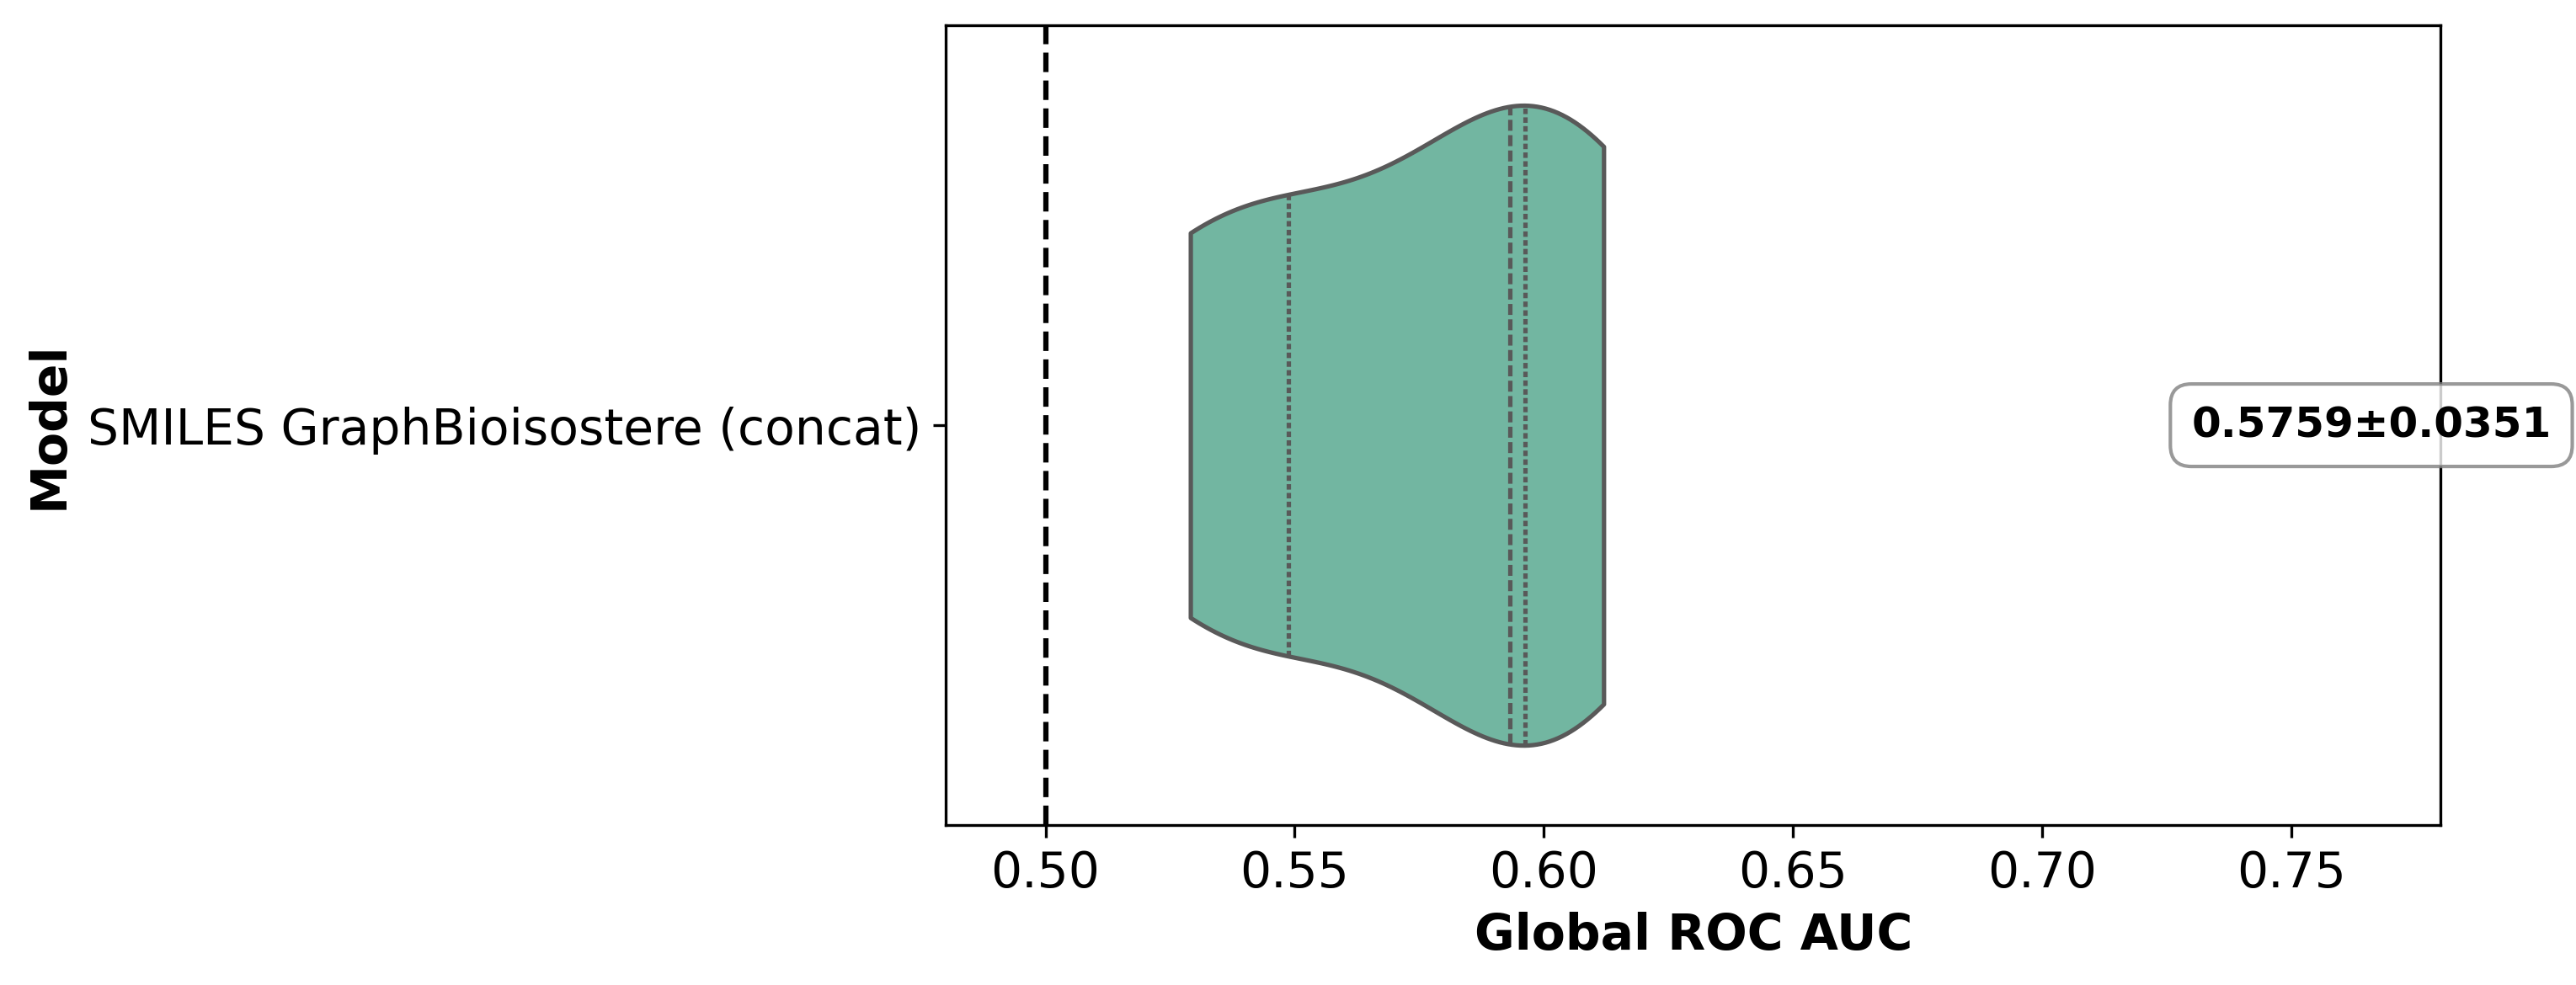


model_comparison_heatmap.png:


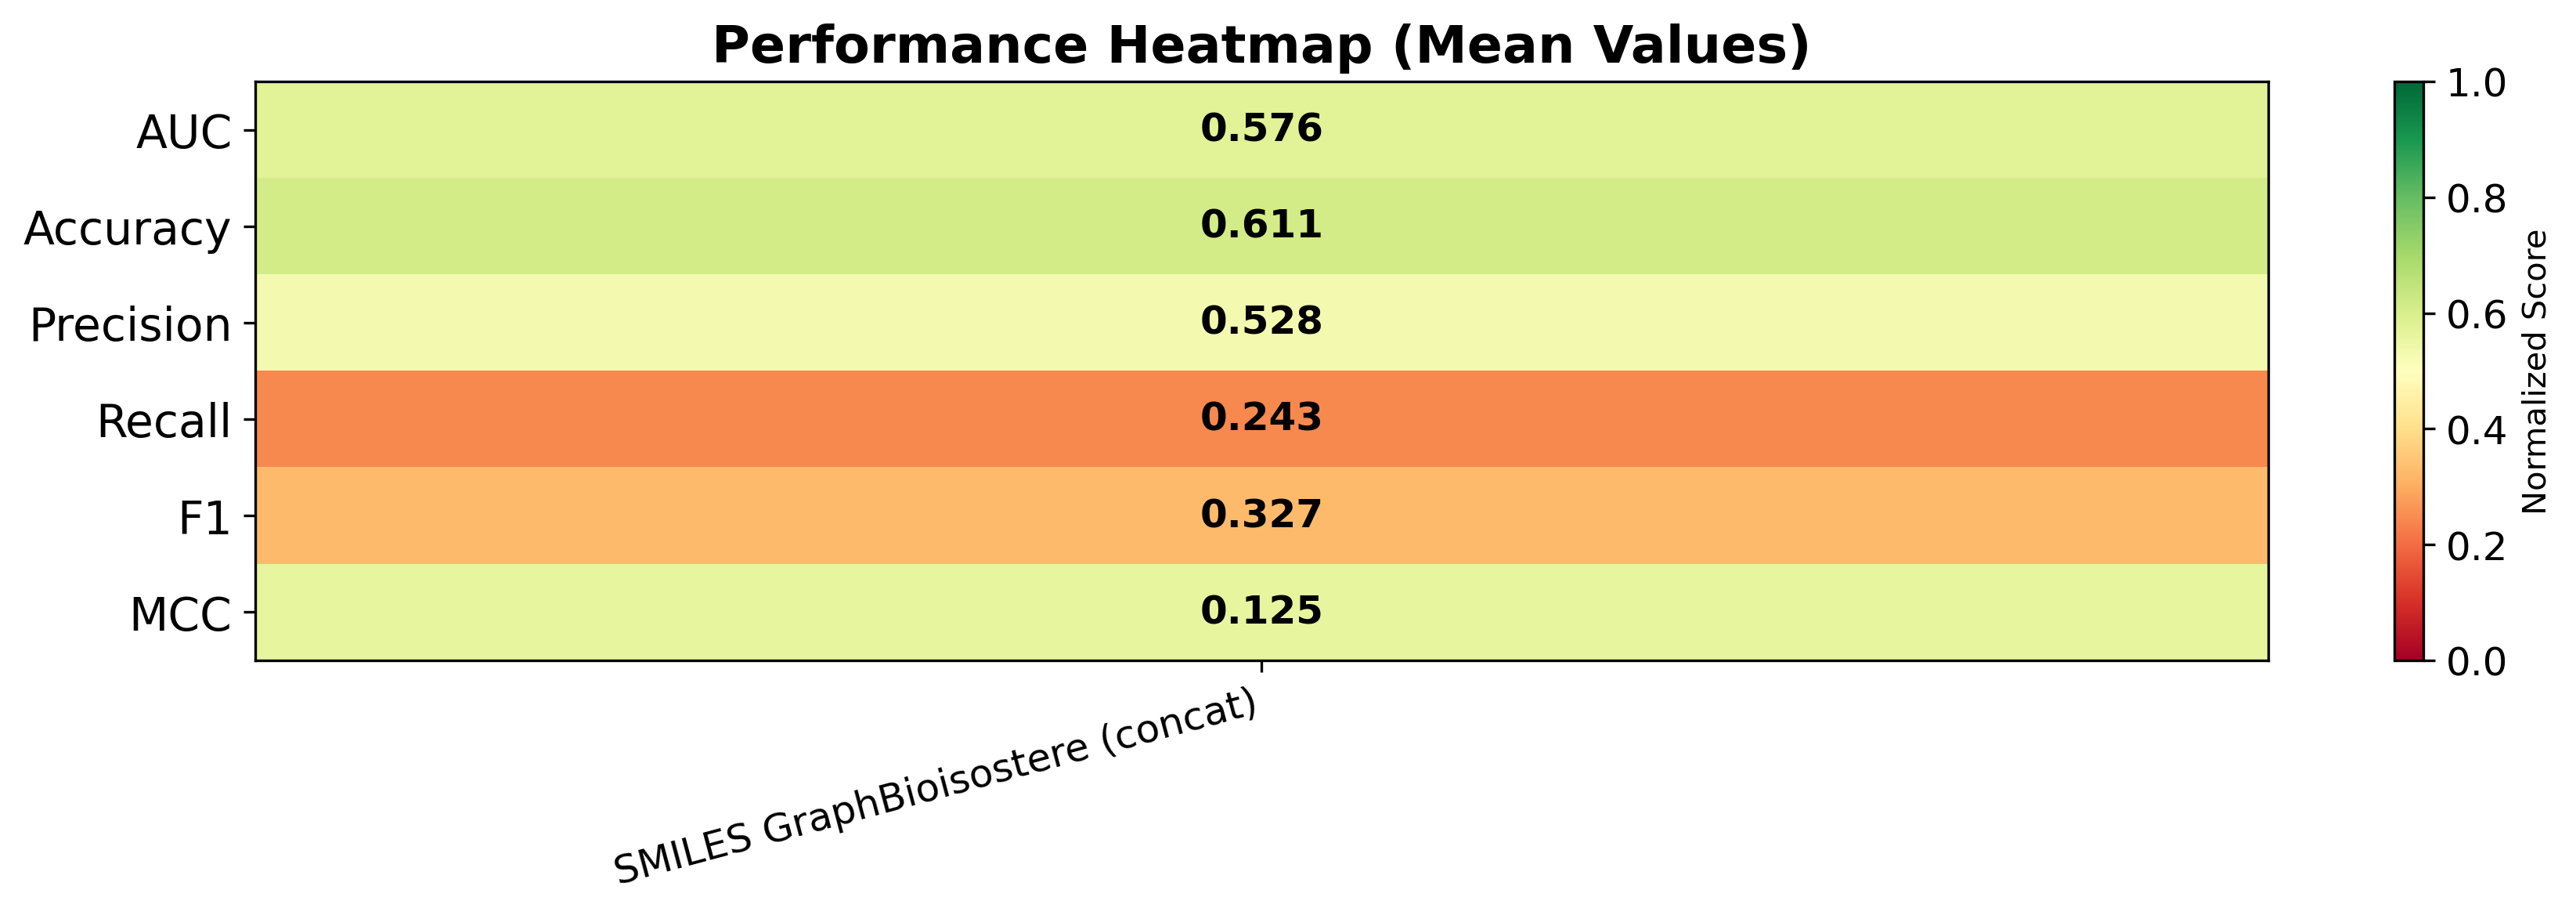


model_comparison_metrics_boxplot.png:


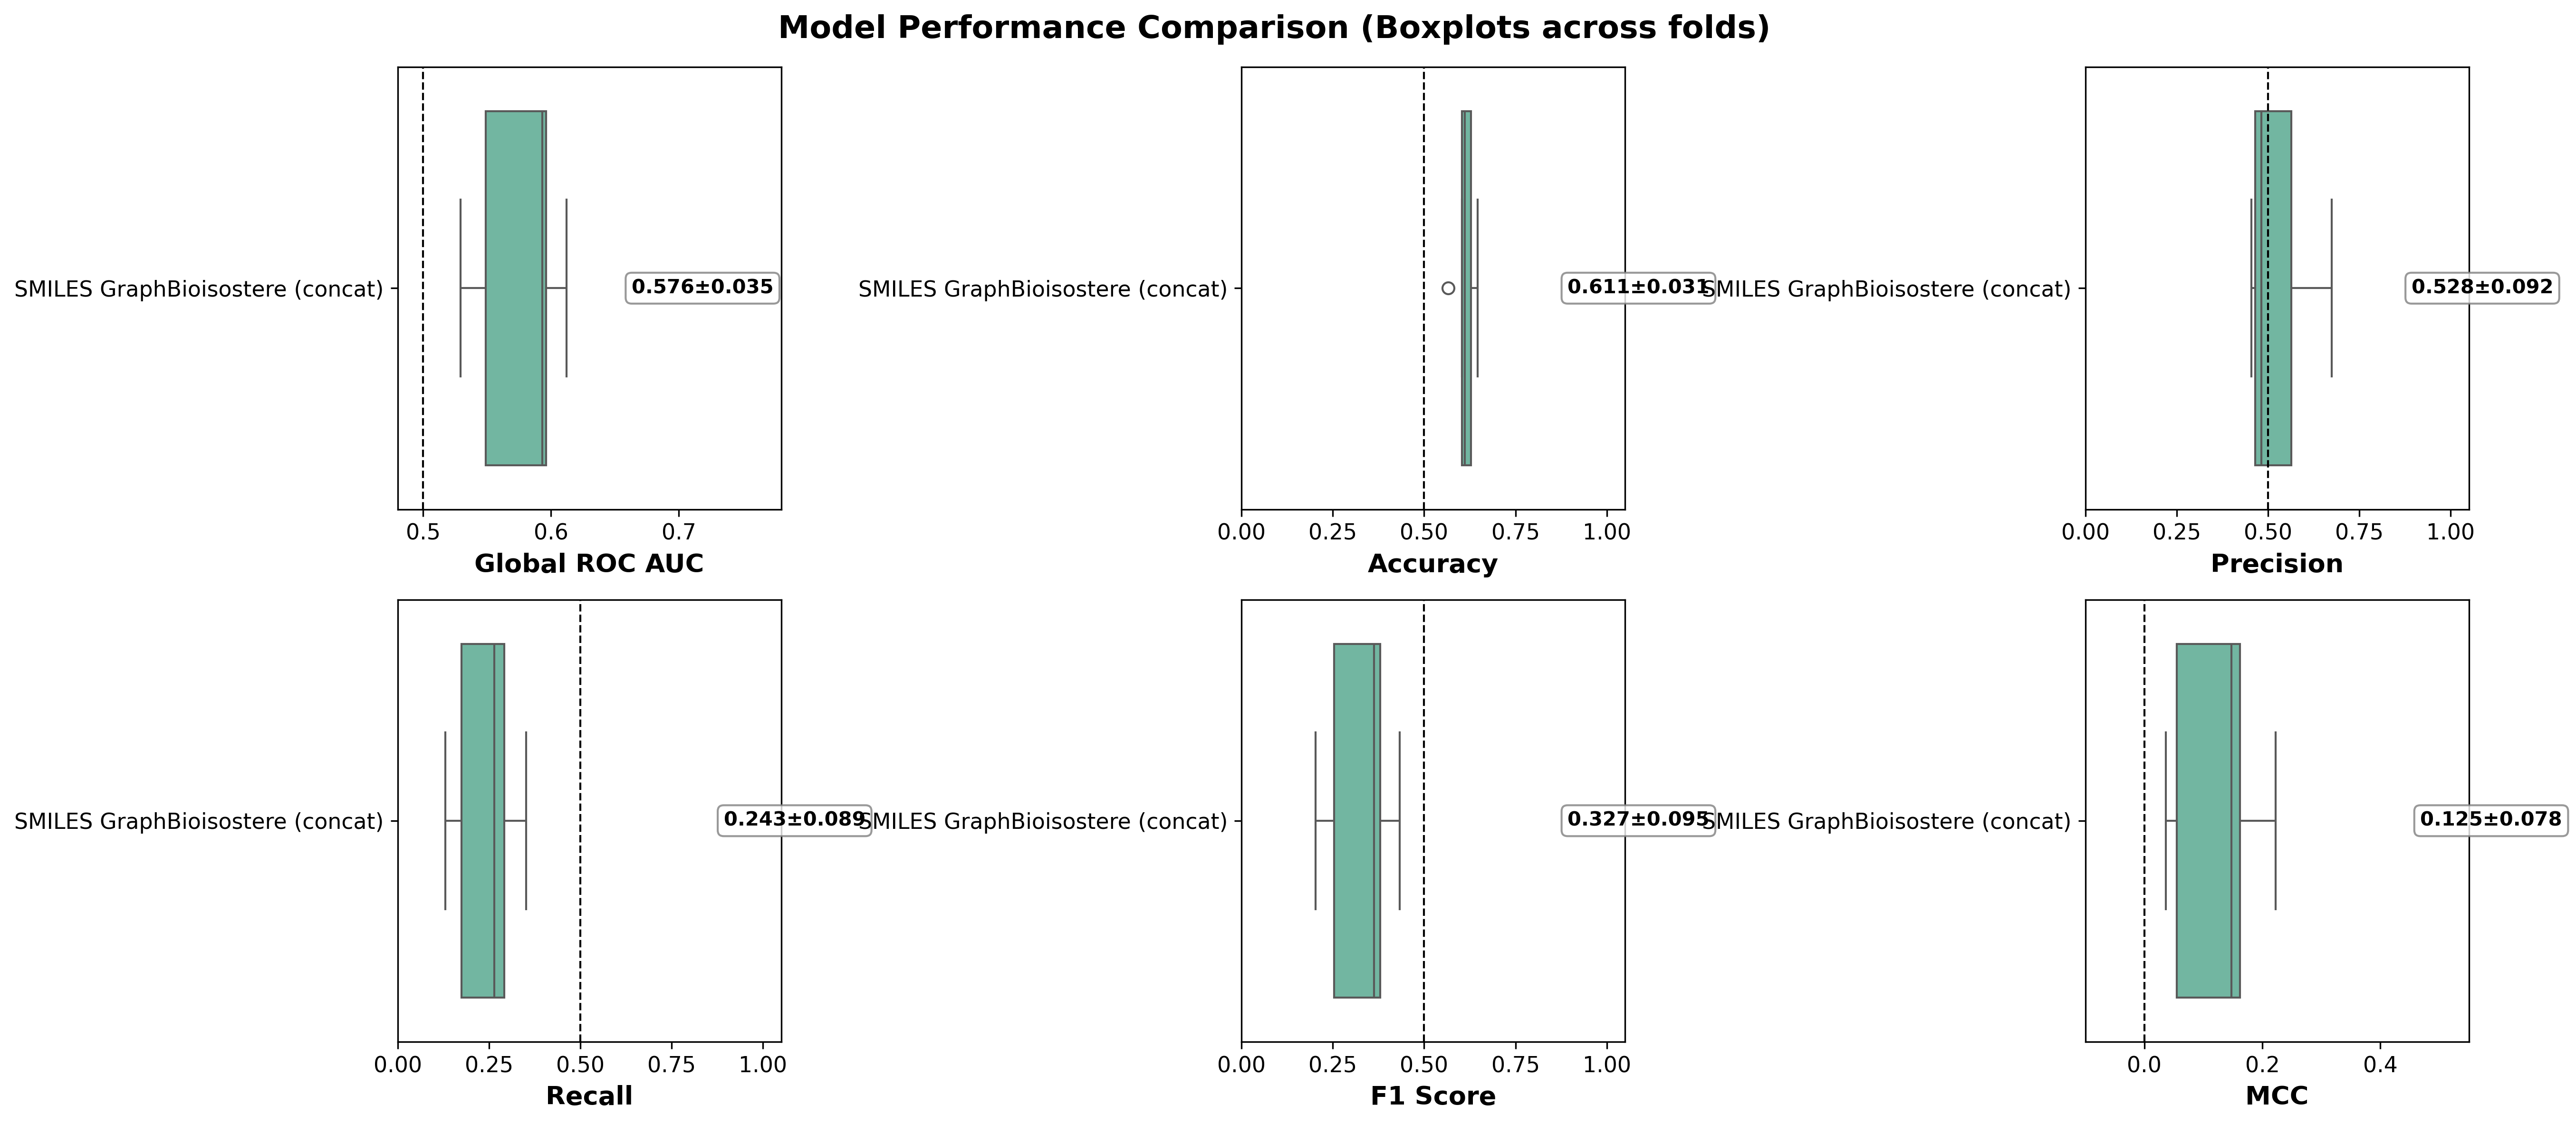


model_comparison_radar.png:


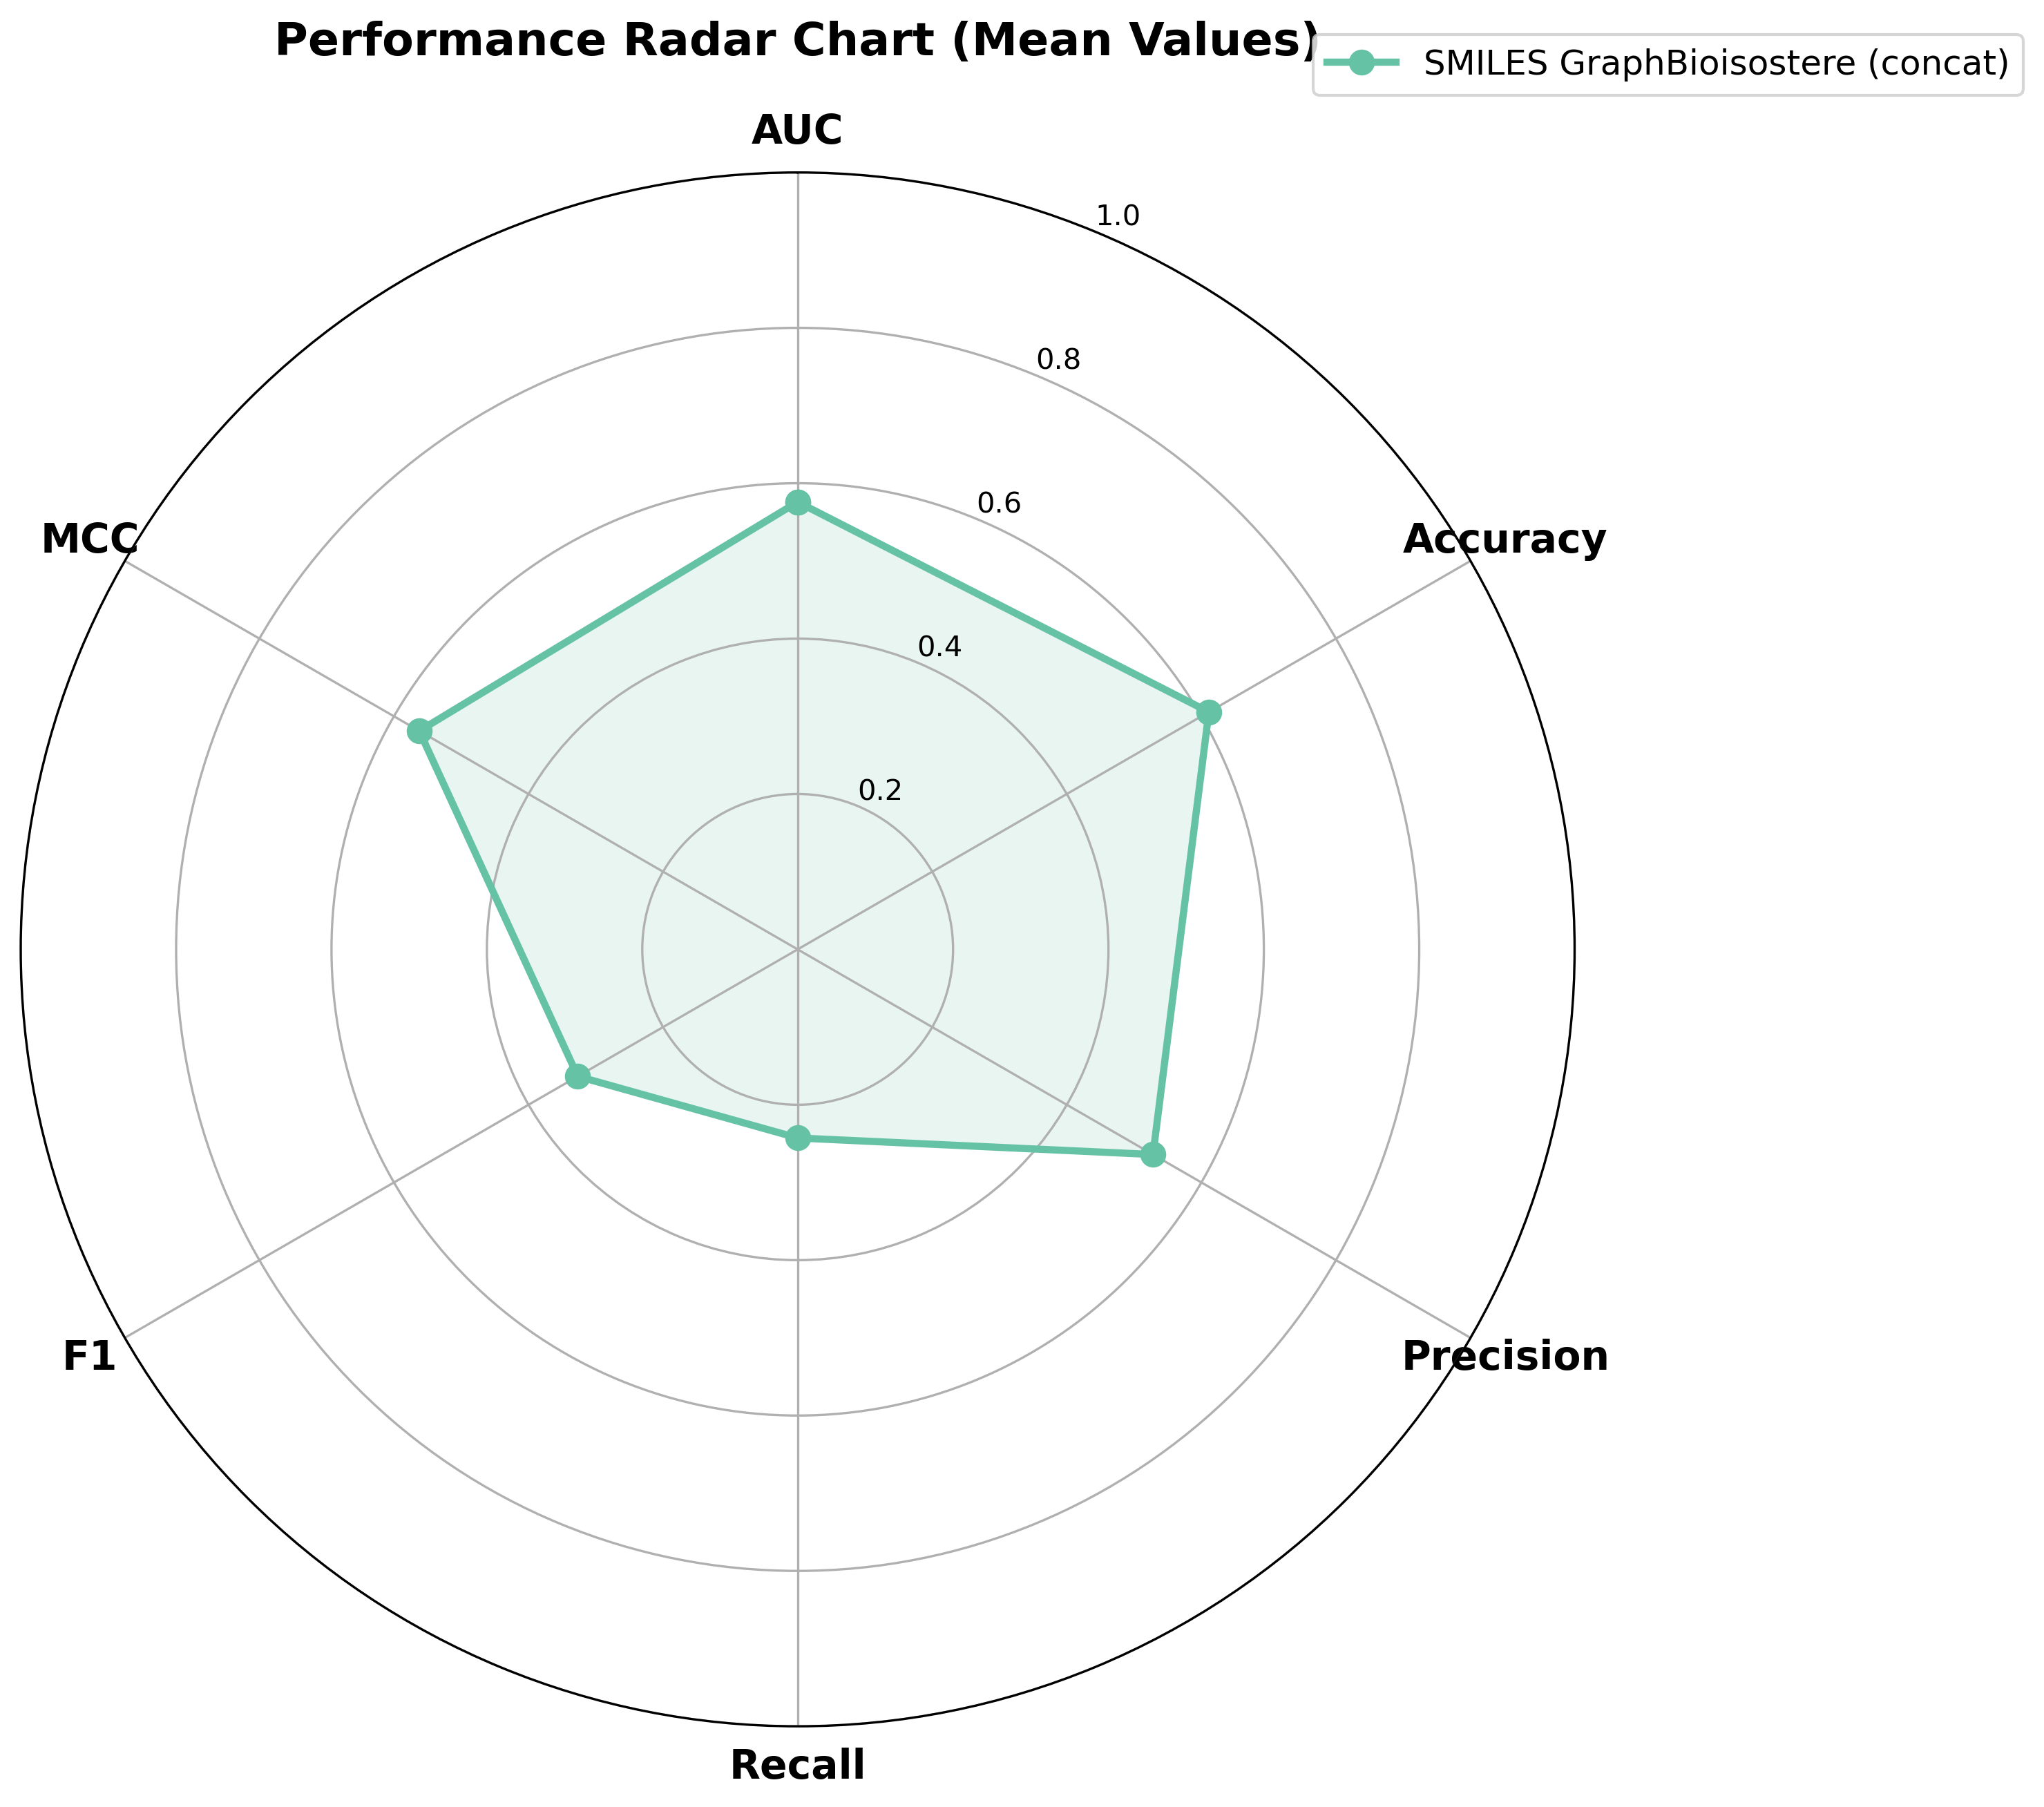

In [ ]:
# 生成された比較図を表示
from IPython.display import Image, display

print("=== 生成された比較図 ===\n")

if comparison_figures_dir.exists():
    for fig_file in sorted(comparison_figures_dir.glob(f'*.{figure_format}')):
        print(f"{fig_file.name}:")
        if figure_format in ['png', 'jpg', 'jpeg', 'gif']:
            display(Image(filename=str(fig_file)))
        print()
else:
    print("図ディレクトリが見つかりません")